In [1]:
# === PROJECT INITIALISATION ===

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Dates and time manipulation
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Modelling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Optional advanced models
import xgboost as xgb

# Explainable AI
import shap

# Notebook settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Environment initialised. Libraries imported. Drive mounted.")

Mounted at /content/drive
✅ Environment initialised. Libraries imported. Drive mounted.


In [2]:
import os

# Check contents of your Drive folder
drive_path = "/content/drive/MyDrive/"
for root, dirs, files in os.walk(drive_path):
    for file in files:
        if 'xlsx' in file.lower():
            print(os.path.join(root, file))


/content/drive/MyDrive/Colab Notebooks/CapstoneData/revisedRiskScores.xlsx
/content/drive/MyDrive/Colab Notebooks/CapstoneData/plansRevised.xlsx
/content/drive/MyDrive/Colab Notebooks/CapstoneData/vulnRevised.xlsx
/content/drive/MyDrive/Colab Notebooks/CapstoneData/earningsRevised.xlsx
/content/drive/MyDrive/Colab Notebooks/CapstoneData/typesRevised.xlsx


In [3]:
from psutil import virtual_memory
!nvidia-smi

ram_gb = virtual_memory().total / 1e9
print(f"\n💾 Your runtime has {ram_gb:.1f} GB RAM")


Sun Jun 22 23:10:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
# === LOAD CLEANED DATASETS FROM DRIVE ===

# Path to your Capstone data
base_path = '/content/drive/MyDrive/Colab Notebooks/CapstoneData/'

# Load files
df_types = pd.read_excel(base_path + 'typesRevised.xlsx')
df_earnings = pd.read_excel(base_path + 'earningsRevised.xlsx')
df_vuln = pd.read_excel(base_path + 'vulnRevised.xlsx')
df_plans = pd.read_excel(base_path + 'plansRevised.xlsx')
df_risks = pd.read_excel(base_path + 'revisedRiskScores.xlsx')

# Confirm shapes
print("📊 Data Loaded:")
print(f"Types: {df_types.shape}")
print(f"Earnings: {df_earnings.shape}")
print(f"Vulnerability: {df_vuln.shape}")
print(f"Plans: {df_plans.shape}")
print(f"Risk Scores: {df_risks.shape}")

df_plans.head()


📊 Data Loaded:
Types: (32175, 5)
Earnings: (2450, 22)
Vulnerability: (6248, 14)
Plans: (60390, 21)
Risk Scores: (10875, 3)


,AdviserType,DOB,Nationality,ClientRef,ClientMigrationRef,CRMContactId,ServiceStatusName,DefaultPostCode,DefaultCountry,PlanType,PlanGroup,TotalRegPremium,TotalLumpSum,PolicyStatus,PolicyStatusDate,IOReference,Currency,Vulnerability,VulnerabilityType,VulnerabilityDateAssessed,VulnerabilityDatetobeReviewed
0,Financial Planning,1972-10-25,British,11992343-12444405,3674432000177 [IFR742],12444405,Transactional,CV11 6AS,United Kingdom,Personal Pension Plan,Pension,0.0,10092.27,In force,2009-04-08,IOB23223586,GBP,NaN,NaN,NaT,NaT
1,Financial Planning,1972-10-25,British,11992343-12444405,3674432000177 [IFR742],12444405,Transactional,CV11 6AS,United Kingdom,Group Personal Pension,Pension,0.0,19921.00,In force,2016-11-01,IOB30996817,GBP,NaN,NaN,NaT,NaT
2,Financial Planning,1943-02-11,British,11913526-12444408,3674432000873 [IFR742],12444408,Bespoke,S42 7BZ,United Kingdom,Cash Account,Savings/Deposit,0.0,0.00,In force,2025-04-17,IOB75892654,GBP,No,NaN,2024-03-20,2026-03-20
3,Financial Planning,1943-02-11,British,11913526-12444408,3674432000873 [IFR742],12444408,Bespoke,S42 7BZ,United Kingdom,Pension Annuity,Pension,0.0,207706.40,In force,2013-04-05,IOB23214192,GBP,No,NaN,2024-03-20,2026-03-20
4,Financial Planning,1943-02-11,British,11913526-12444408,3674432000873 [IFR742],12444408,Bespoke,S42 7BZ,United Kingdom,ISA,ISA,0.0,306549.68,In force,2005-07-14,IOB23216453,GBP,No,NaN,2024-03-20,2026-03-20


In [5]:
# Check how many risk scores are usable
print("🎯 Total Risk Score Records:", df_risks.shape[0])
print("✅ Non-null FinalATR values:", df_risks['FinalATR'].notna().sum())
print("🟡 Null FinalATR values:", df_risks['FinalATR'].isna().sum())
print("📊 Has Risk Score TRUE:", df_risks['Has Risk Score'].sum())
print("📊 Has Risk Score FALSE:", (~df_risks['Has Risk Score']).sum())

# === FILTER risk scores to usable entries ===
df_risks = df_risks[
    (df_risks["Has Risk Score"] == True) &
    (df_risks["FinalATR"].notna())
].copy()
df_risks["Client.Id"] = df_risks["Client.Id"].astype(int)
df_risks = df_risks.rename(columns={"Client.Id": "CRMContactId"})


🎯 Total Risk Score Records: 10875
✅ Non-null FinalATR values: 4878
🟡 Null FinalATR values: 5997
📊 Has Risk Score TRUE: 4812
📊 Has Risk Score FALSE: 6063


In [6]:
# === STEP 1: Merge earnings into plans ===
df_plans = pd.merge(df_plans, df_earnings, left_on="ClientRef", right_on="Client Reference", how="left")

# === STEP 2: Add vulnerability data ===
df_merged = pd.merge(df_plans, df_vuln, on="CRMContactId", how="left")

# === STEP 3: Add types (rename ID) ===
df_types = df_types.rename(columns={"Id": "CRMContactId"})
df_merged = pd.merge(df_merged, df_types, on="CRMContactId", how="left")

# === STEP 4: Add cleaned risk scores ===
df_merged["CRMContactId"] = df_merged["CRMContactId"].astype(int)
df_merged = pd.merge(df_merged, df_risks, on="CRMContactId", how="left")

# === STEP 5: Drop rows with no plan data (e.g. risk-only clients) ===
df_merged = df_merged[df_merged["PlanType"].notna()].copy()

print(f"✅ Final merged DataFrame shape: {df_merged.shape}")
print(f"📉 % with missing FinalATR: {df_merged['FinalATR'].isna().mean():.2%}")

df_merged.to_csv(base_path + "master_df.csv", index=False)

✅ Final merged DataFrame shape: (60418, 62)
📉 % with missing FinalATR: 58.59%


In [7]:
from IPython.display import display

# Show as styled HTML table
pd.set_option('display.max_columns', None)  # Show all columns
display(df_merged.head(5))


,AdviserType,DOB,Nationality_x,ClientRef_x,ClientMigrationRef,CRMContactId,ServiceStatusName,DefaultPostCode,DefaultCountry,PlanType,PlanGroup,TotalRegPremium,TotalLumpSum,PolicyStatus,PolicyStatusDate,IOReference,Currency,Vulnerability,VulnerabilityType,VulnerabilityDateAssessed,VulnerabilityDatetobeReviewed,Client Reference,Client Migration Reference,Marital Status,Employment Status,Occupation,Salary,Total Gross Monthly Income,Total Net Monthly Income,Total Monthly Affordability Income,Total Monthly Expenditure,Total Monthly Disposable Income,Agreed Single Amount for Investment,Total Funds Available,Smoker,IsRetired,IsMarriedOrPartnered,HasSalaryReported,HighDisposableIncome,HasInvestmentIntent,IsFinanciallySecure,HasNegativeDisposable,Occupation Group,ClientRef_y,VulnerabilityDetails,Flag_FinancialStruggle,Flag_MentalHealth,Flag_PhysicalHealth,Flag_Bereavement,Flag_Elderly,Flag_LanguageBarrier,Flag_LowComprehension,Flag_DivorceOrSeparation,Flag_ComplexPortfolio,Flag_FamilyResponsibilities,NumVulnerabilityTags,Client Type,Nationality_y,UK Resident,Gender,Has Risk Score,FinalATR
0,Financial Planning,1972-10-25,British,11992343-12444405,3674432000177 [IFR742],12444405,Transactional,CV11 6AS,United Kingdom,Personal Pension Plan,Pension,0.0,10092.27,In force,2009-04-08,IOB23223586,GBP,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Person,British,True,Male,NaN,NaN
1,Financial Planning,1972-10-25,British,11992343-12444405,3674432000177 [IFR742],12444405,Transactional,CV11 6AS,United Kingdom,Group Personal Pension,Pension,0.0,19921.00,In force,2016-11-01,IOB30996817,GBP,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Person,British,True,Male,NaN,NaN
2,Financial Planning,1943-02-11,British,11913526-12444408,3674432000873 [IFR742],12444408,Bespoke,S42 7BZ,United Kingdom,Cash Account,Savings/Deposit,0.0,0.00,In force,2025-04-17,IOB75892654,GBP,No,NaN,2024-03-20,2026-03-20,11913526-12444408,3674432000873 [IFR742],Married,Retired,NaN,102739.0,9522.21,6462.86,9253.97,13954.12,-4700.16,NaN,0.0,False,True,True,True,0.0,True,0.0,1.0,Unknown,11913526-12444408,Paul and Christine are not vulnerable - they a...,True,False,False,False,False,False,True,False,True,False,3.0,Person,British,True,Male,True,5.0
3,Financial Planning,1943-02-11,British,11913526-12444408,3674432000873 [IFR742],12444408,Bespoke,S42 7BZ,United Kingdom,Pension Annuity,Pension,0.0,207706.40,In force,2013-04-05,IOB23214192,GBP,No,NaN,2024-03-20,2026-03-20,11913526-12444408,3674432000873 [IFR742],Married,Retired,NaN,102739.0,9522.21,6462.86,9253.97,13954.12,-4700.16,NaN,0.0,False,True,True,True,0.0,True,0.0,1.0,Unknown,11913526-12444408,Paul and Christine are not vulnerable - they a...,True,False,False,False,False,False,True,False,True,False,3.0,Person,British,True,Male,True,5.0
4,Financial Planning,1943-02-11,British,11913526-12444408,3674432000873 [IFR742],12444408,Bespoke,S42 7BZ,United Kingdom,ISA,ISA,0.0,306549.68,In force,2005-07-14,IOB23216453,GBP,No,NaN,2024-03-20,2026-03-20,11913526-12444408,3674432000873 [IFR742],Married,Retired,NaN,102739.0,9522.21,6462.86,9253.97,13954.12,-4700.16,NaN,0.0,False,True,True,True,0.0,True,0.0,1.0,Unknown,11913526-12444408,Paul and Christine are not vulnerable - they a...,True,False,False,False,False,False,True,False,True,False,3.0,Person,British,True,Male,True,5.0


EDA BLOCK

2.1 Exploratory Data Analysis (EDA)
The initial phase involved a detailed examination of the merged dataset (df_merged), which integrates plan data, policy metrics, and client-level attributes. This stage sought to establish an informed understanding of the data structure, completeness, target class balance, and potential explanatory variables.

Target Variable (FinalATR)
The target distribution (FinalATR) is notably right-skewed, with the majority of non-missing entries clustered between 4 and 7. Approximately 35,000 records (~58%) lack a risk score and were retained for potential use in the test set or future imputation strategies (Figure X). The non-missing distribution (Figure Y) guided the selection of a multiclass classification task.

Missingness
A ranked barplot (Figure Z) and corresponding heatmap (Figure A) show that many financial features (e.g., Total Gross/Net Income, Investment Intent) suffer from substantial missingness (>60%). Patterns suggest blockwise missingness rather than random absence, likely driven by client segmentation. This will inform imputation strategies in Phase 2.

Salary vs Risk
To assess numerical skew and potential relationship with risk tolerance, salary was capped at £500k to reduce the influence of extreme outliers. The resulting boxplot (Figure B) reveals significant overlap across FinalATR categories, suggesting that salary alone may not be predictive but could still interact with other variables.

Employment Status & Risk
A stacked bar chart (Figure C) of FinalATR proportions by Employment Status exposes high variability between groups. For example, "Houseperson" and "Long Term Illness" categories show polarised scores. This finding supports the later creation of domain-specific categorical encodings and explains a portion of class separation.

A high-cardinality feature inspection revealed several categorical fields with significant unique levels, including Occupation (419), Nationality (63), and PlanType (137). These were flagged for grouping or compression during Phase 2 to prevent overfitting and ensure model generalisation.

PolicyAge was created from the Policy Start Date and was included in the numerical correlation matrix. It showed weak correlation with most features but retained for potential interactions.

Correlation Matrix
A heatmap of numerical features (Figure D) revealed strong collinearity between disposable income, affordability, and net income. Several flags (e.g., HighDisposableIncome, HasNegativeDisposable) appear aligned with these distributions and will be retained for model input after redundancy is addressed.

Insert These Charts into Report:

| Label    | Figure Filename                                 | Placement                       |
| -------- | ----------------------------------------------- | ------------------------------- |
| Figure X | Distribution of Risk Scores (with Missing)      | Start of EDA section            |
| Figure Y | Distribution of Risk Scores (excluding Missing) | Directly after Figure X         |
| Figure Z | Missing Values by Column (%)                    | Start of Missingness subsection |
| Figure A | Missingness Heatmap (Top 20 Columns)            | After Figure Z                  |
| Figure B | Boxplot of Salary by FinalATR (Capped)          | Numerical feature subsection    |
| Figure C | Employment Status vs FinalATR (Stacked %)       | Categorical feature subsection  |
| Figure D | Correlation Matrix                              | End of EDA section              |


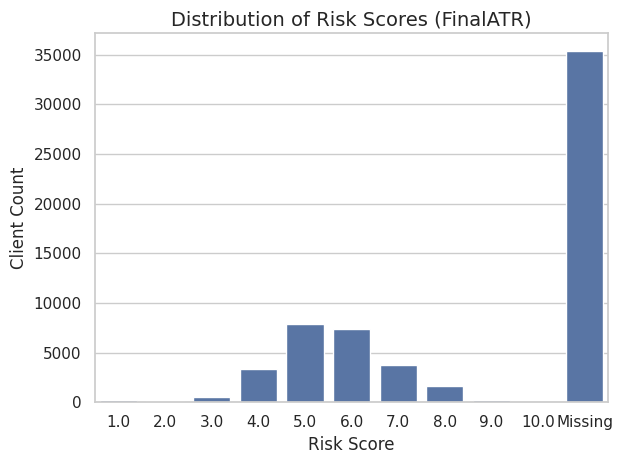

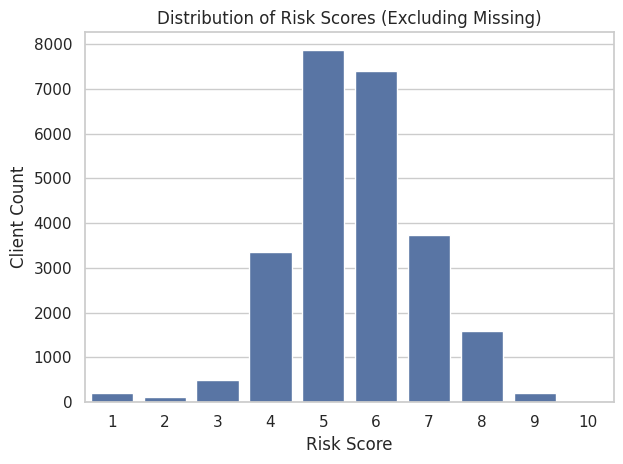

🔍 Breakdown of FinalATR values:
FinalATR
1.0       198
2.0       120
3.0       505
4.0      3363
5.0      7871
6.0      7409
7.0      3747
8.0      1597
9.0       199
10.0       10
NaN     35399
Name: count, dtype: int64


In [8]:
# 📊 Distribution of FinalATR values (including nulls)
atr_counts = df_merged['FinalATR'].value_counts(dropna=False).sort_index()
atr_labels = [str(x) if pd.notna(x) else "Missing" for x in atr_counts.index]

sns.barplot(x=atr_labels, y=atr_counts.values)
plt.title("Distribution of Risk Scores (FinalATR)", fontsize=14)
plt.xlabel("Risk Score", fontsize=12)
plt.ylabel("Client Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Risk Score (FinalATR) without missing
atr_notna = df_merged['FinalATR'].dropna().value_counts().sort_index()
sns.barplot(x=atr_notna.index.astype(int), y=atr_notna.values)
plt.title("Distribution of Risk Scores (Excluding Missing)")
plt.xlabel("Risk Score", fontsize=12)
plt.ylabel("Client Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("🔍 Breakdown of FinalATR values:")
print(atr_counts)

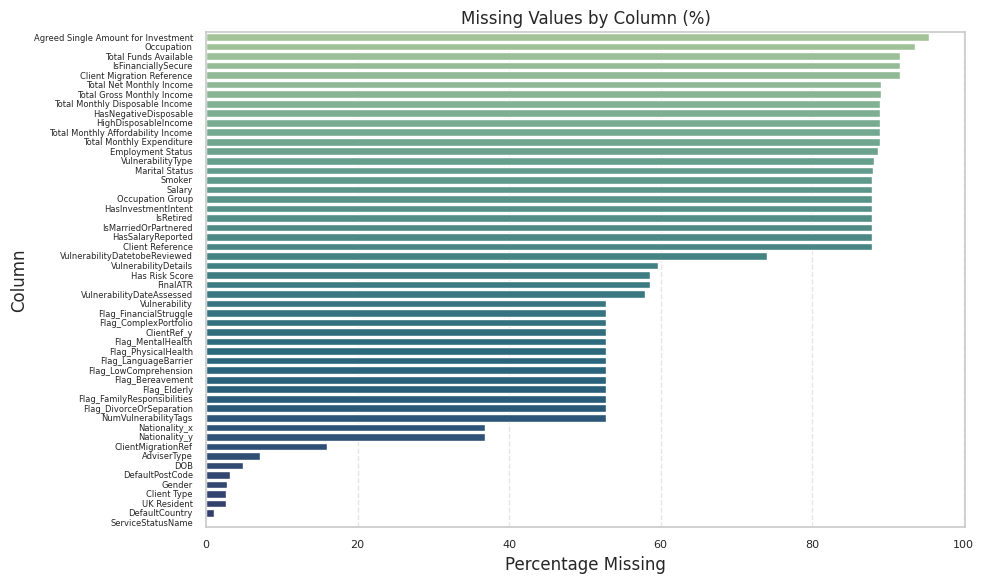

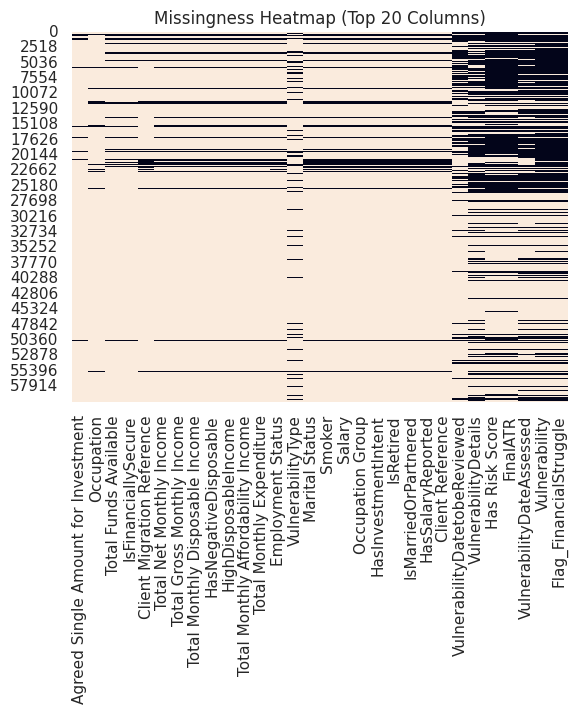

In [9]:
# 📉 Missing data heatmap and percentage summary
missing_percent = df_merged.isnull().mean().sort_values(ascending=False) * 100
missing_df = missing_percent[missing_percent > 0].reset_index()
missing_df.columns = ['Column', '% Missing']

plt.figure(figsize=(10, 6))  # Taller chart = more label spacing
sns.barplot(data=missing_df, x='% Missing', y='Column', palette='crest')
plt.title("Missing Values by Column (%)", fontsize=12)
plt.xlabel("Percentage Missing", fontsize=12)
plt.ylabel("Column", fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=6)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Optional: visualise heatmap for top 20 columns with most missing
top_missing_cols = missing_df['Column'].head(30).tolist()
sns.heatmap(df_merged[top_missing_cols].isnull(), cbar=False)
plt.title("Missingness Heatmap (Top 20 Columns)")
plt.show()

In [10]:
# 🧮 Identify variable types
categoricals = df_merged.select_dtypes(include='object').columns.tolist()
numerics = df_merged.select_dtypes(include=['int64', 'float64']).columns.tolist()
binaries = [col for col in df_merged.columns if df_merged[col].dropna().nunique() == 2]

print(f"🔤 Categorical columns ({len(categoricals)}):\n{categoricals}\n")
print(f"🔢 Numeric columns ({len(numerics)}):\n{numerics}\n")
print(f"⚖️ Binary columns ({len(binaries)}):\n{binaries}")

🔤 Categorical columns (42):
['AdviserType', 'Nationality_x', 'ClientRef_x', 'ClientMigrationRef', 'ServiceStatusName', 'DefaultPostCode', 'DefaultCountry', 'PlanType', 'PlanGroup', 'PolicyStatus', 'IOReference', 'Currency', 'Vulnerability', 'VulnerabilityType', 'Client Reference', 'Client Migration Reference', 'Marital Status', 'Employment Status', 'Occupation', 'Smoker', 'IsRetired', 'IsMarriedOrPartnered', 'HasSalaryReported', 'HasInvestmentIntent', 'Occupation Group', 'ClientRef_y', 'VulnerabilityDetails', 'Flag_FinancialStruggle', 'Flag_MentalHealth', 'Flag_PhysicalHealth', 'Flag_Bereavement', 'Flag_Elderly', 'Flag_LanguageBarrier', 'Flag_LowComprehension', 'Flag_DivorceOrSeparation', 'Flag_ComplexPortfolio', 'Flag_FamilyResponsibilities', 'Client Type', 'Nationality_y', 'UK Resident', 'Gender', 'Has Risk Score']

🔢 Numeric columns (16):
['CRMContactId', 'TotalRegPremium', 'TotalLumpSum', 'Salary', 'Total Gross Monthly Income', 'Total Net Monthly Income', 'Total Monthly Affordabili

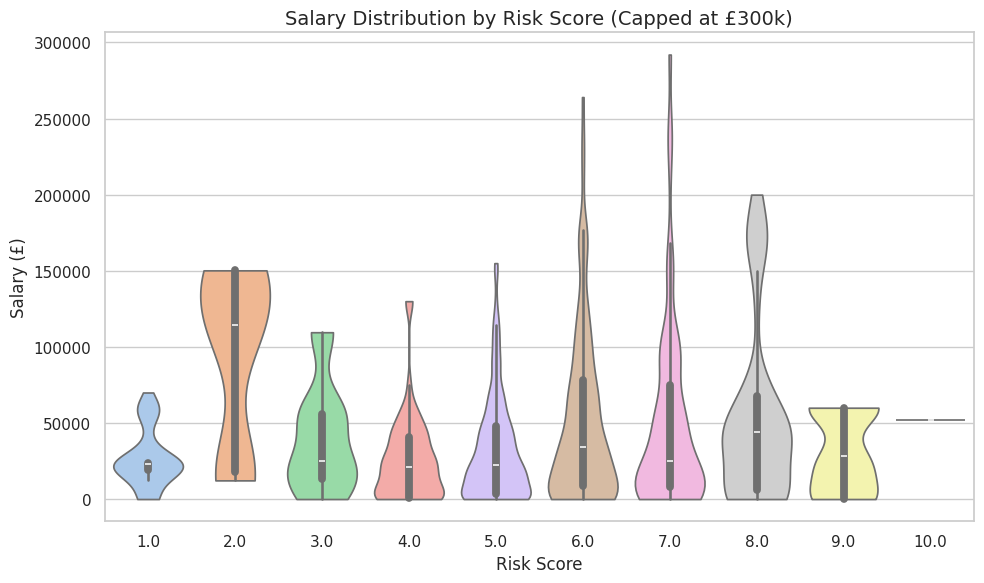

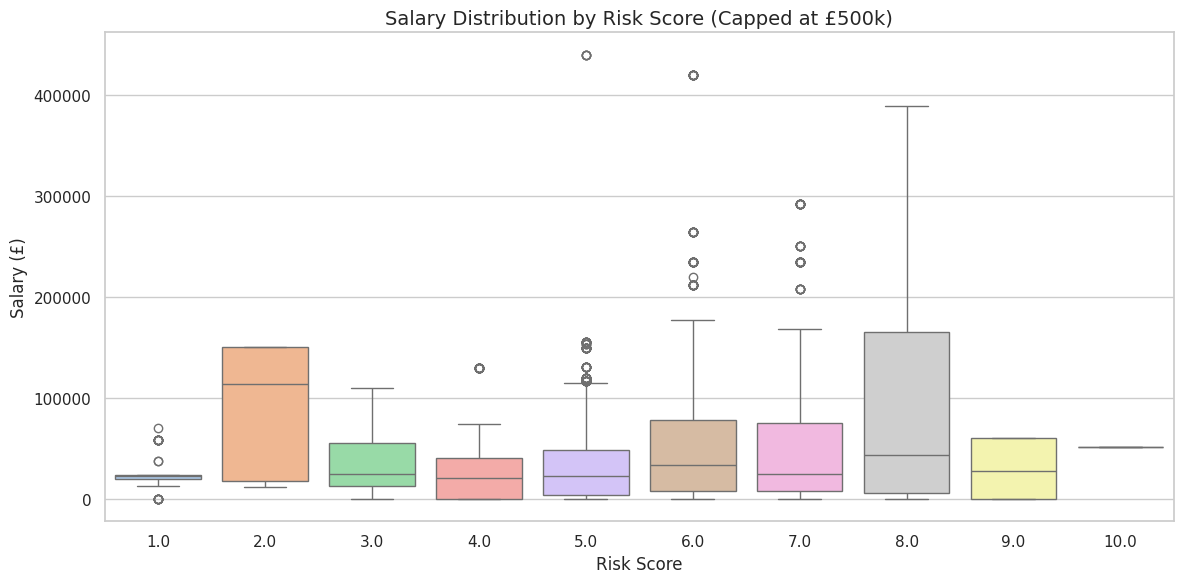

In [11]:
# Focused violin with salary capped at 200k
df_plot = df_merged[df_merged['FinalATR'].notna() & df_merged['Salary'].notna()]
df_plot = df_plot[df_plot['Salary'] < 300000]

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_plot, x='FinalATR', y='Salary', palette='pastel', cut=0)
plt.title("Salary Distribution by Risk Score (Capped at £300k)", fontsize=14)
plt.xlabel("Risk Score")
plt.ylabel("Salary (£)")
plt.tight_layout()
plt.show()

# Boxplot of Salary capped at £500k
df_plot = df_merged[df_merged['FinalATR'].notna() & df_merged['Salary'].notna()]
df_plot = df_plot[df_plot['Salary'] < 500000]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='FinalATR', y='Salary', palette='pastel')
plt.title("Salary Distribution by Risk Score (Capped at £500k)", fontsize=14)
plt.xlabel("Risk Score")
plt.ylabel("Salary (£)")
plt.tight_layout()
plt.show()



🔍 Unique Employment Statuses:
Employment Status
NaN                  53564
Employed              3245
Retired               2513
Self-Employed          700
Company Director       289
Houseperson             46
Unemployed              24
Student                 15
Other                   10
Contract Worker          7
Long Term Illness        5
Name: count, dtype: int64


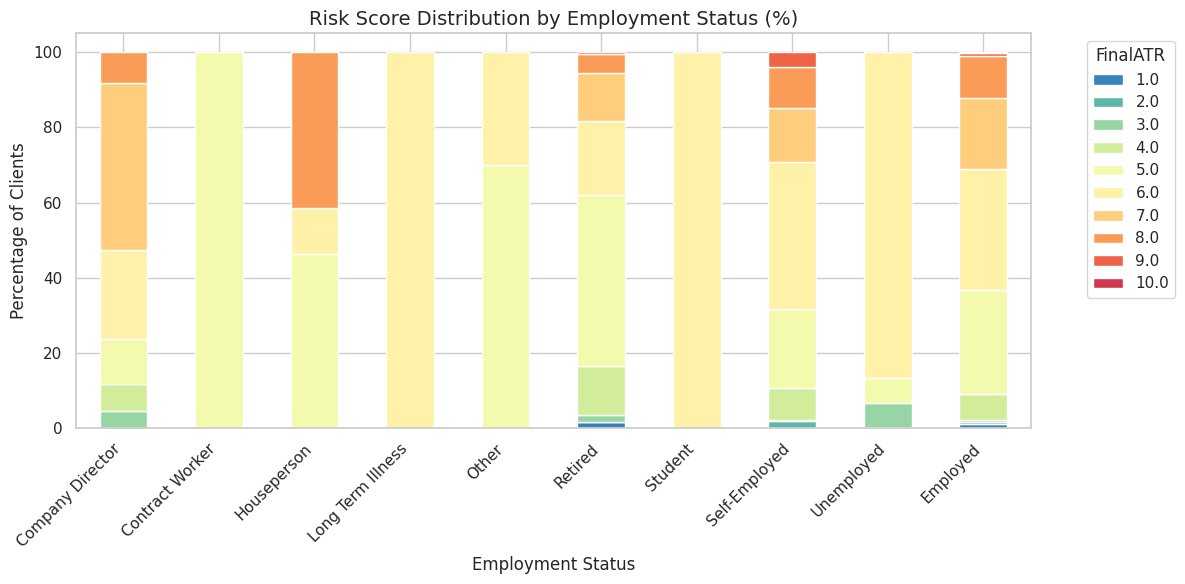

In [12]:
# Review unique employment statuses
employment_counts = df_merged['Employment Status'].value_counts(dropna=False)
print("🔍 Unique Employment Statuses:")
print(employment_counts)

from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap

# Reversed so that index 0 = FinalATR 1 = blue → 10 = red
ordered_palette = sns.color_palette("Spectral", 10)[::-1]  # Reverse it!

# FinalATR columns in numeric order (1 to 10)
ctab = pd.crosstab(df_merged['Employment Status'], df_merged['FinalATR'])
ctab = ctab.reindex(sorted(ctab.columns), axis=1)

# Calculate %
ctab_pct = ctab.div(ctab.sum(axis=1), axis=0) * 100
ctab_pct = ctab_pct.loc[ctab_pct.sum(axis=1).sort_values(ascending=False).index]

# Plot with reversed palette
ctab_pct.plot(kind='bar',
              stacked=True,
              figsize=(12, 6),
              colormap=ListedColormap(ordered_palette))
plt.title("Risk Score Distribution by Employment Status (%)", fontsize=14)
plt.ylabel("Percentage of Clients")
plt.xticks(rotation=45, ha='right')
plt.legend(title='FinalATR', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




🔍 Checking missingness in Salary vs IsRetired


Salary Missing,False,True
IsRetired,,
False,4742,0
True,2540,0
Missing,0,53136


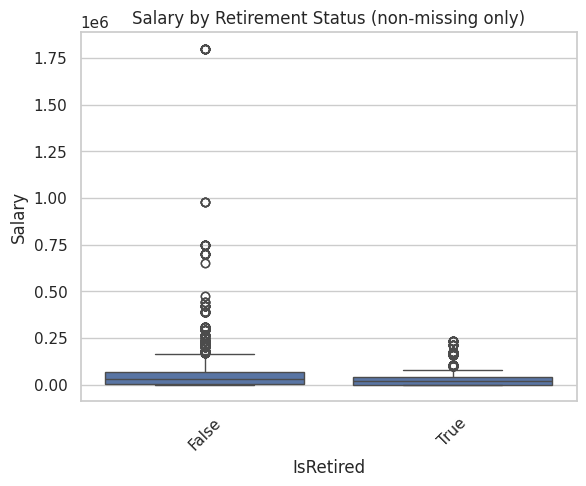

In [13]:
# 💰 Investigate Salary and IsRetired BEFORE dropping them
if 'Salary' in df_merged.columns and 'IsRetired' in df_merged.columns:
    print("🔍 Checking missingness in Salary vs IsRetired")
    cross_tab = pd.crosstab(
        df_merged['IsRetired'].fillna('Missing'),
        df_merged['Salary'].isna(),
        rownames=['IsRetired'],
        colnames=['Salary Missing']
    )
    display(cross_tab)

    # Optional visual
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_merged['SalaryPresent'] = df_merged['Salary'].notna().astype(int)
    sns.boxplot(data=df_merged[df_merged['Salary'].notna()], x='IsRetired', y='Salary')
    plt.title("Salary by Retirement Status (non-missing only)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ One of the required columns not found. Please recheck spelling.")


In [14]:
# 🔍 Check high-cardinality categoricals
high_card_cols = ['PlanType', 'PlanGroup', 'Nationality_x', 'Occupation', 'Currency']

for col in high_card_cols:
    print(f"\n🧮 {col} — {df_merged[col].nunique()} unique values")
    display(df_merged[col].value_counts().head(15))
    print("-" * 60)



🧮 PlanType — 137 unique values


,count
PlanType,
Group Personal Pension,9743
Personal Pension Plan,8060
ISA,5789
Term Protection,4913
Cash Account,4611
Group Death In Service,3837
Savings Account,1784
Mortgage,1735
Wrap,1366


------------------------------------------------------------

🧮 PlanGroup — 6 unique values


,count
PlanGroup,
Pension,21460
Other,21435
Savings/Deposit,8049
ISA,6165
Protection,2052
Tax Shelter,1257


------------------------------------------------------------

🧮 Nationality_x — 63 unique values


,count
Nationality_x,
British,35626
English,496
Welsh,425
Irish,199
German,177
Scottish,160
Italian,144
Dutch,105
Australian,100


------------------------------------------------------------

🧮 Occupation — 419 unique values


,count
Occupation,
Veterinary Surgeon,303
Director,209
Retired,132
Company Director,122
Vet,90
Commercial Director,64
Engineer,57
Managing Director,46
Invigilator,43


------------------------------------------------------------

🧮 Currency — 7 unique values


,count
Currency,
GBP,60408
CAD,4
ZAR,2
AUD,1
NZD,1
HKD,1
ILS,1


------------------------------------------------------------


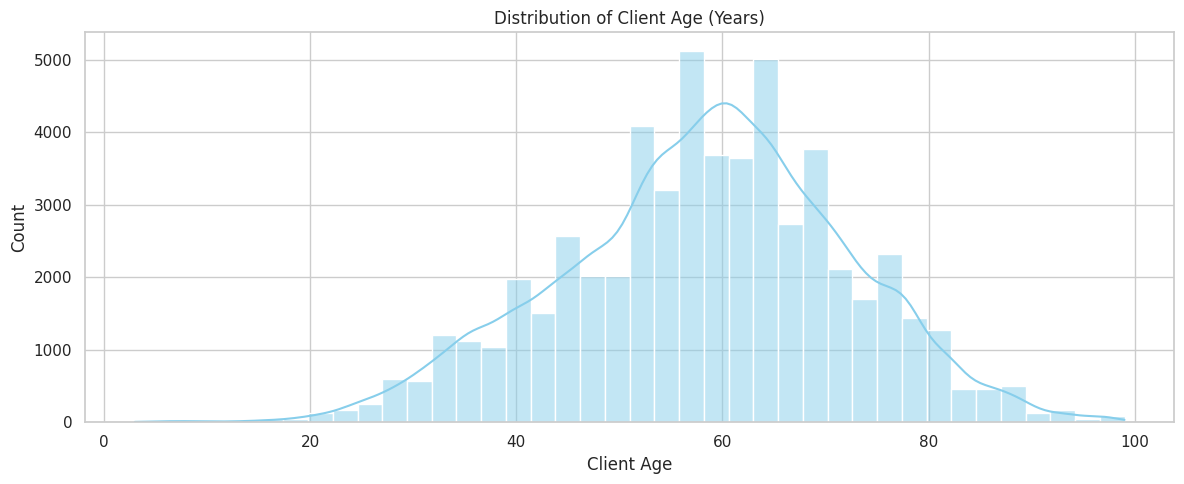

In [15]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 📆 Calculate Client Age from DOB (into df_merged)
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'], errors='coerce')
df_merged['Client_Age'] = df_merged['DOB'].apply(
    lambda x: relativedelta(datetime.today(), x).years if pd.notnull(x) else None
)

# 📊 Plot Distribution of Client Age
df_valid_age = df_merged[df_merged['Client_Age'].notna() & (df_merged['Client_Age'] < 100)]

plt.figure(figsize=(12, 5))
sns.histplot(df_valid_age['Client_Age'], bins=40, kde=True, color='skyblue')
plt.title("Distribution of Client Age (Years)")
plt.xlabel("Client Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


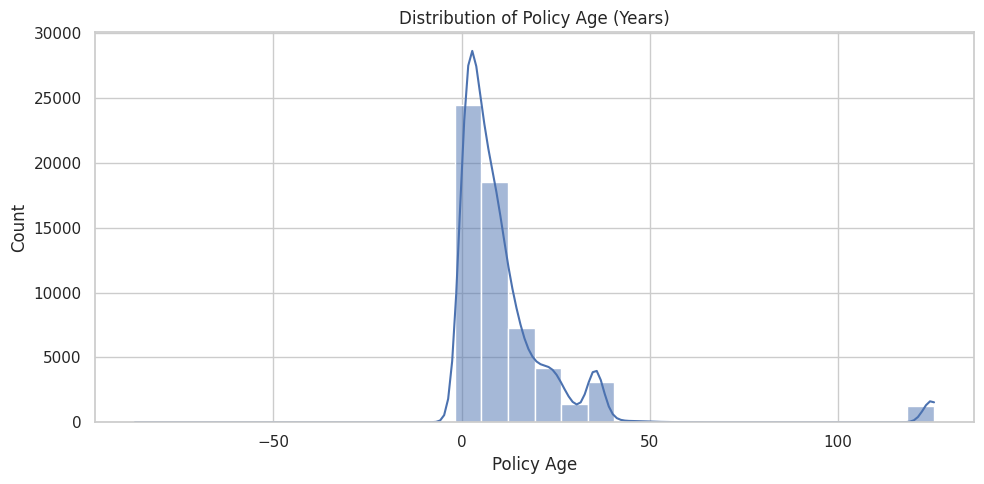

In [16]:
# 📆 Calculate Policy Age from PolicyStatusDate
df_merged['PolicyStatusDate'] = pd.to_datetime(df_merged['PolicyStatusDate'], errors='coerce')
df_merged['PolicyAge'] = ((pd.to_datetime("today") - df_merged['PolicyStatusDate']).dt.days / 365.25).round(1)

# ⏳ Quick distribution check
plt.figure(figsize=(10, 5))
sns.histplot(df_merged['PolicyAge'].dropna(), bins=30, kde=True)
plt.title("Distribution of Policy Age (Years)")
plt.xlabel("Policy Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


📉 Dropping columns due to:
🔸 High Missingness (>85% missing):
Agreed Single Amount for Investment    0.954583
Total Funds Available                  0.916267
IsFinanciallySecure                    0.916267
dtype: float64

🔸 Zero Variance:
Series([], dtype: int64)


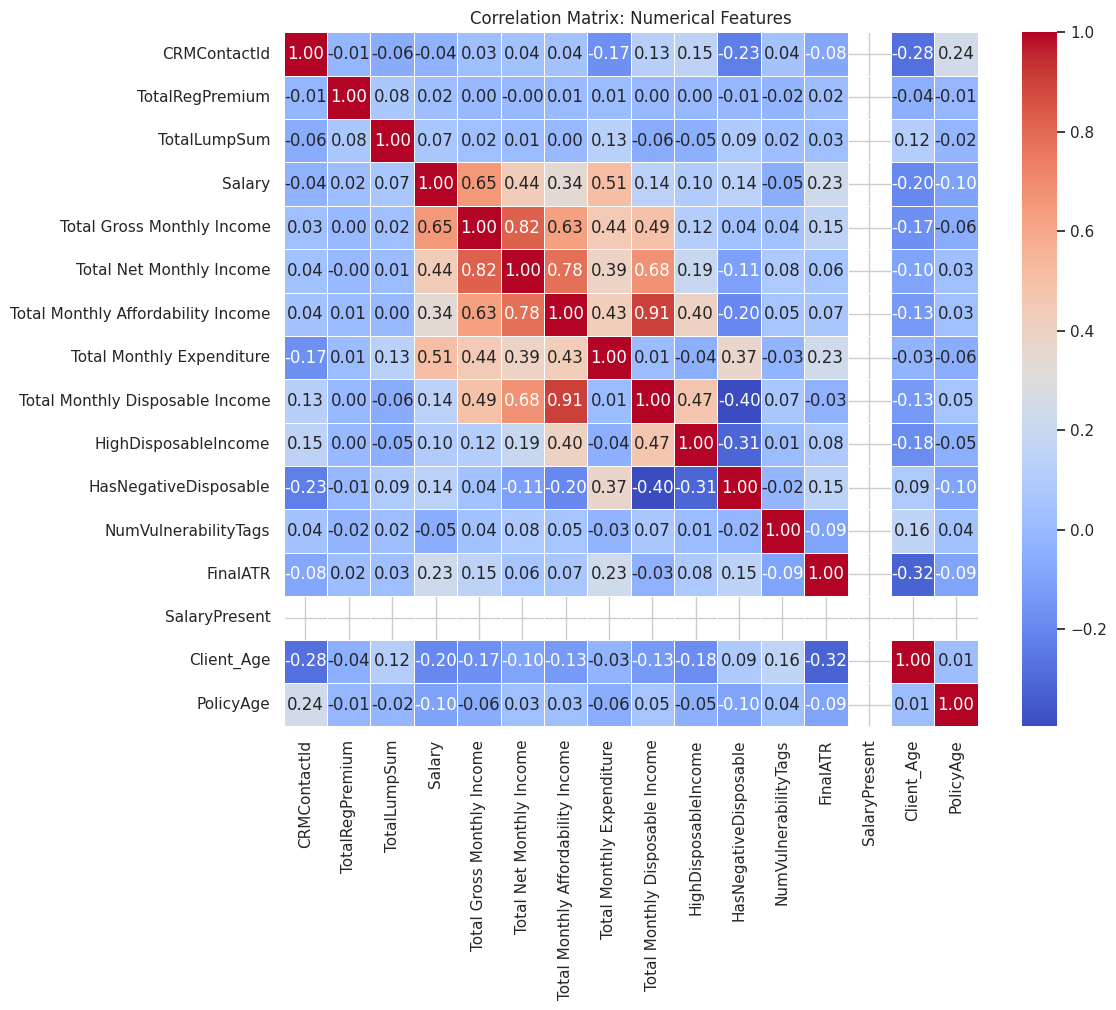

In [17]:
# ✅ Robust Correlation Matrix for Numerical Columns

# Step 1 – Create copy of df_merged for correlation purposes
df_corr = df_merged.copy()

# Step 2 – Identify numeric columns only
numerics = df_corr.select_dtypes(include='number')

# Step 3 – Drop columns with too much missingness OR zero variance
threshold = 0.9  # Must have at least 10% data
missingness = numerics.isna().mean()
variance = numerics.nunique()

# Optional: Print which columns are being dropped
print("📉 Dropping columns due to:")
print("🔸 High Missingness (>85% missing):")
print(missingness[missingness > threshold])
print("\n🔸 Zero Variance:")
print(variance[variance <= 1])

# Apply filters
numerics = numerics.loc[:, (missingness <= threshold) & (variance > 1)]

# Step 4 – Drop any remaining rows with NaNs (only rows used in corr)
df_corr_clean = numerics.dropna()

# Step 5 – Compute & Visualise Correlation Matrix
corr = df_corr_clean.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title("Correlation Matrix: Numerical Features")
plt.tight_layout()
plt.show()


DATA ENGINEERING BLOCK

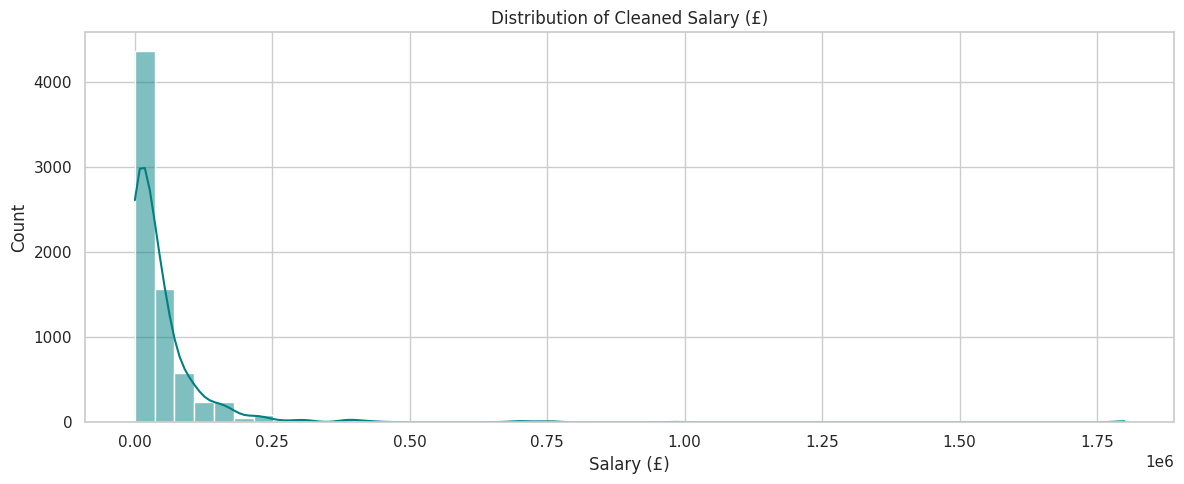

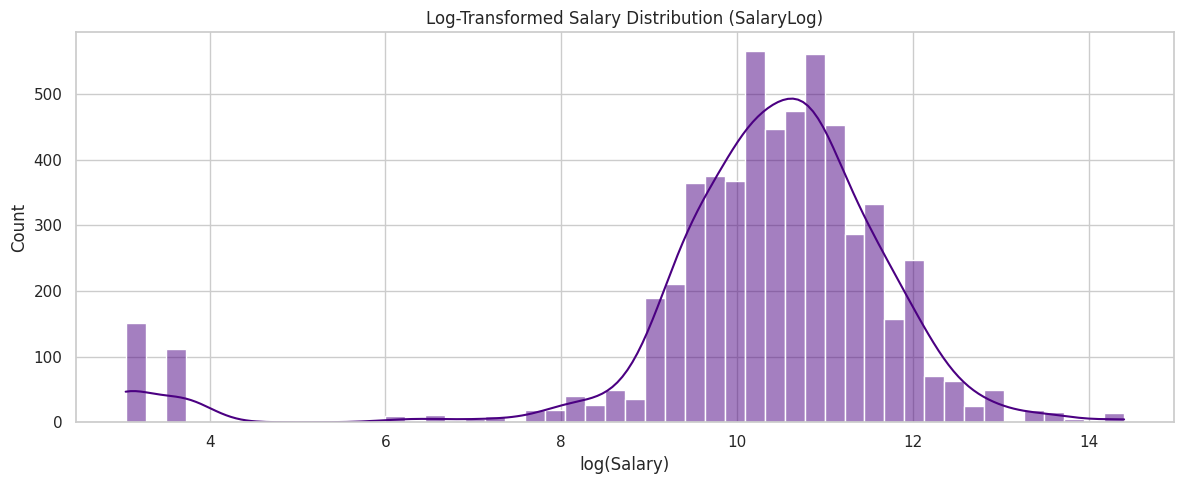

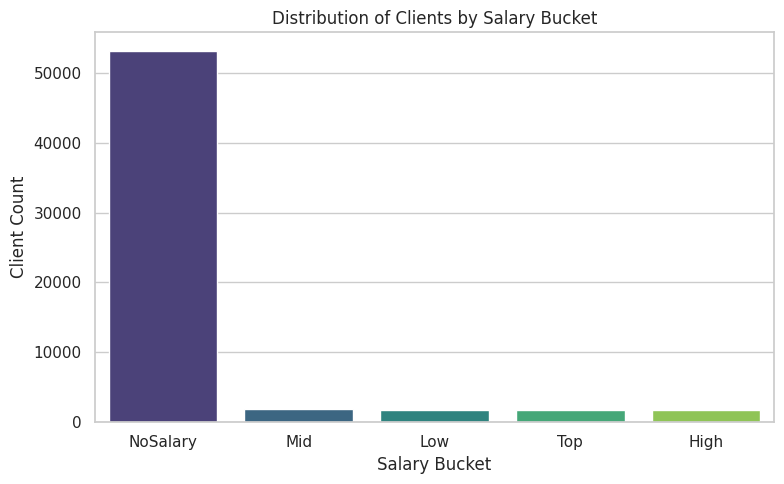

📦 Salary Bucket Value Counts:


,count
SalaryBucket,
NoSalary,53136
Mid,1884
Low,1822
Top,1819
High,1757


In [18]:
# === Salary Feature Engineering with "NoSalary" Bucket ===

# Step 1: Create CleanedSalary (copied from Salary)
df_merged['CleanedSalary'] = df_merged['Salary']

# Step 2: Apply log transform to reduce skew
df_merged['SalaryLog'] = df_merged['Salary'].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > 0 else None)

# Step 3: Create salary quartile buckets (only for valid values)
try:
    df_merged['SalaryBucket'] = pd.qcut(
        df_merged['Salary'],
        q=4,
        labels=["Low", "Mid", "High", "Top"],
        duplicates='drop'
    )
except ValueError:
    print("⚠️ Not enough non-null unique Salary values to create buckets.")

# Step 4: Add and assign a new "NoSalary" category for nulls
df_merged['SalaryBucket'] = df_merged['SalaryBucket'].cat.add_categories('NoSalary')
df_merged['SalaryBucket'] = df_merged['SalaryBucket'].fillna('NoSalary')

# Step 5: Visualise CleanedSalary distribution
plt.figure(figsize=(12, 5))
sns.histplot(df_merged['CleanedSalary'].dropna(), bins=50, kde=True, color='teal')
plt.title("Distribution of Cleaned Salary (£)")
plt.xlabel("Salary (£)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Step 6: Visualise SalaryLog distribution
plt.figure(figsize=(12, 5))
sns.histplot(df_merged['SalaryLog'].dropna(), bins=50, kde=True, color='indigo')
plt.title("Log-Transformed Salary Distribution (SalaryLog)")
plt.xlabel("log(Salary)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Step 7: Visualise Salary Bucket distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_merged, x='SalaryBucket', palette='viridis', order=df_merged['SalaryBucket'].value_counts().index)
plt.title("Distribution of Clients by Salary Bucket")
plt.xlabel("Salary Bucket")
plt.ylabel("Client Count")
plt.tight_layout()
plt.show()

# Step 8: Print SalaryBucket counts
print("📦 Salary Bucket Value Counts:")
display(df_merged['SalaryBucket'].value_counts(dropna=False))


🧮 Revised Age Bucket Counts:
AgeBucket
Retiree                   21039
Approaching Retirement    14981
Midlife                    8480
Elderly                    6909
Young                      5898
NaN                        3111
Name: count, dtype: int64


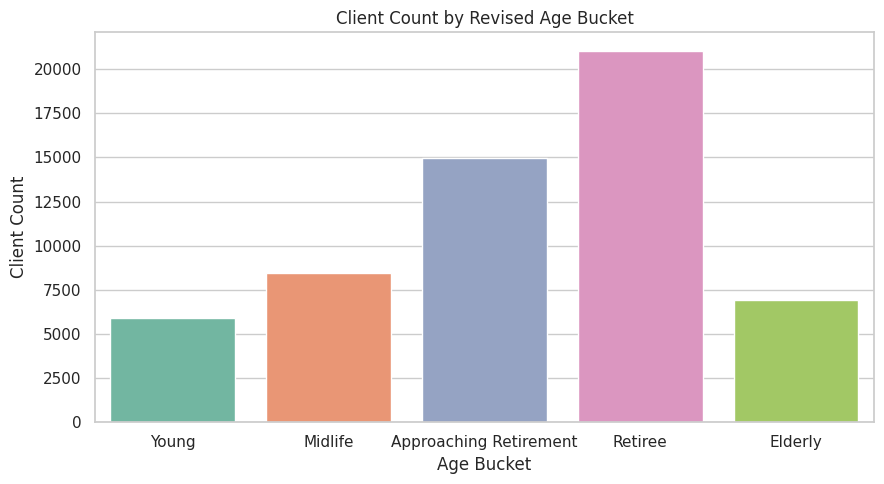

In [19]:
# 🧱 Create Revised Age Buckets (5 groups)

# Define age bin edges and labels
age_bins = [0, 40, 50, 60, 75, 120]
age_labels = ['Young', 'Midlife', 'Approaching Retirement', 'Retiree', 'Elderly']

# Apply binning to Client_Age
df_merged['AgeBucket'] = pd.cut(df_merged['Client_Age'], bins=age_bins, labels=age_labels, right=False)

# 🧮 Quick count by bucket
print("🧮 Revised Age Bucket Counts:")
print(df_merged['AgeBucket'].value_counts(dropna=False))

# 📊 Visualise the new buckets
plt.figure(figsize=(9, 5))
sns.countplot(data=df_merged, x='AgeBucket', palette='Set2')
plt.title("Client Count by Revised Age Bucket")
plt.ylabel("Client Count")
plt.xlabel("Age Bucket")
plt.tight_layout()
plt.show()


🧮 Policy Age Bucket Counts:
PolicyAgeBucket
10y+     22251
5-10y    14486
2-5y     11977
<1y       6179
1-2y      5507
NaN         18
Name: count, dtype: int64


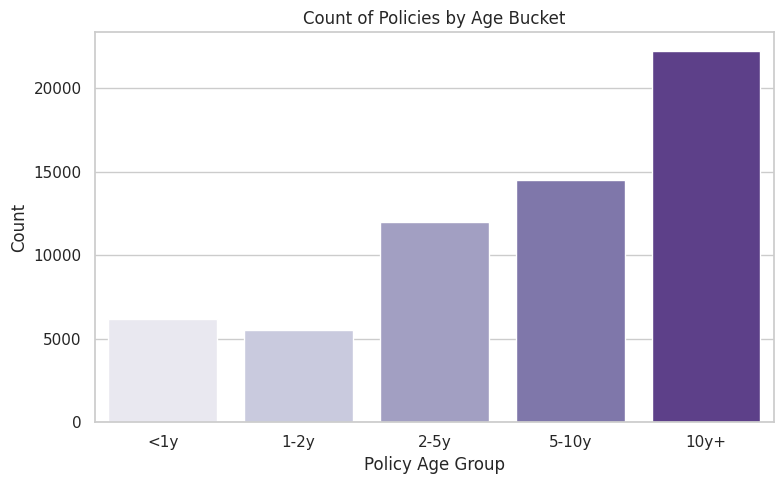

In [20]:
# 🧱 Create Policy Age Buckets to capture non-linear effects in downstream models

# Define bin edges and labels (business logic aligned)
policy_bins = [0, 1, 2, 5, 10, float("inf")]
policy_labels = ['<1y', '1-2y', '2-5y', '5-10y', '10y+']

# Apply binning to PolicyAge
df_merged['PolicyAgeBucket'] = pd.cut(df_merged['PolicyAge'], bins=policy_bins, labels=policy_labels, right=False)

# 🧮 Count policies per bucket
print("🧮 Policy Age Bucket Counts:")
print(df_merged['PolicyAgeBucket'].value_counts(dropna=False))

# 📊 Visualise distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df_merged, x='PolicyAgeBucket', palette='Purples')
plt.title("Count of Policies by Age Bucket")
plt.xlabel("Policy Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [21]:
# 🔁 Step 1: Automatically drop all right-side (_y) columns created during merging
cols_to_drop = [col for col in df_merged.columns if col.endswith('_y')]

# 🧼 Step 2: Manually add redundant or superseded fields to drop list
cols_to_drop += [
    # 🔐 Duplicate identifiers and old metadata
    "ClientRef_x", "Client Migration Reference_x", "Client Reference_x",
    "ClientRef_y", "Client Reference_y", "Client Migration Reference_y",
    "IOReference", "Client.Id", "DefaultPostCode", "DefaultCountry", "Currency",

    # 🏢 Adviser or platform metadata (not used in modelling)
    "AdviserType", "ServiceStatusName",

    # 🔄 Raw fields replaced by engineered versions (kept separately)
    "Employment Status_x", "Occupation_x", "Marital Status_x",
    "Agreed Single Amount for Investment_x", "Total Funds Available_x",
    "Total Monthly Disposable Income_x", "Total Monthly Expenditure_x",
    "Total Net Monthly Income_x", "Total Gross Monthly Income_x",

    # 📆 Unstructured vulnerability detail (free text/dates)
    "Vulnerability", "VulnerabilityType", "VulnerabilityDetails",
    "VulnerabilityDateAssessed", "VulnerabilityDatetobeReviewed",

    # 🗂️ Status metadata or fields dropped in scope
    "PolicyStatus", "PolicyStatusDate", "Client Type", "Has Risk Score"
]

# 🧹 Step 3: Drop and create cleaned version
df_merged_cleaned = df_merged.drop(columns=cols_to_drop, errors='ignore')

# 🏷️ Step 4: Move target column to front (optional, improves readability)
cols = ['FinalATR'] + [col for col in df_merged_cleaned.columns if col != 'FinalATR']
df_merged_cleaned = df_merged_cleaned[cols]

print(f"🧼 Cleaned DataFrame shape: {df_merged_cleaned.shape}")
display(df_merged_cleaned.head(5))

🧼 Cleaned DataFrame shape: (60418, 52)


,FinalATR,DOB,Nationality_x,ClientMigrationRef,CRMContactId,PlanType,PlanGroup,TotalRegPremium,TotalLumpSum,Client Reference,Client Migration Reference,Marital Status,Employment Status,Occupation,Salary,Total Gross Monthly Income,Total Net Monthly Income,Total Monthly Affordability Income,Total Monthly Expenditure,Total Monthly Disposable Income,Agreed Single Amount for Investment,Total Funds Available,Smoker,IsRetired,IsMarriedOrPartnered,HasSalaryReported,HighDisposableIncome,HasInvestmentIntent,IsFinanciallySecure,HasNegativeDisposable,Occupation Group,Flag_FinancialStruggle,Flag_MentalHealth,Flag_PhysicalHealth,Flag_Bereavement,Flag_Elderly,Flag_LanguageBarrier,Flag_LowComprehension,Flag_DivorceOrSeparation,Flag_ComplexPortfolio,Flag_FamilyResponsibilities,NumVulnerabilityTags,UK Resident,Gender,SalaryPresent,Client_Age,PolicyAge,CleanedSalary,SalaryLog,SalaryBucket,AgeBucket,PolicyAgeBucket
0,NaN,1972-10-25,British,3674432000177 [IFR742],12444405,Personal Pension Plan,Pension,0.0,10092.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Male,0,52.0,16.2,NaN,NaN,NoSalary,Approaching Retirement,10y+
1,NaN,1972-10-25,British,3674432000177 [IFR742],12444405,Group Personal Pension,Pension,0.0,19921.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Male,0,52.0,8.6,NaN,NaN,NoSalary,Approaching Retirement,5-10y
2,5.0,1943-02-11,British,3674432000873 [IFR742],12444408,Cash Account,Savings/Deposit,0.0,0.00,11913526-12444408,3674432000873 [IFR742],Married,Retired,NaN,102739.0,9522.21,6462.86,9253.97,13954.12,-4700.16,NaN,0.0,False,True,True,True,0.0,True,0.0,1.0,Unknown,True,False,False,False,False,False,True,False,True,False,3.0,True,Male,1,82.0,0.2,102739.0,11.539957,Top,Elderly,<1y
3,5.0,1943-02-11,British,3674432000873 [IFR742],12444408,Pension Annuity,Pension,0.0,207706.40,11913526-12444408,3674432000873 [IFR742],Married,Retired,NaN,102739.0,9522.21,6462.86,9253.97,13954.12,-4700.16,NaN,0.0,False,True,True,True,0.0,True,0.0,1.0,Unknown,True,False,False,False,False,False,True,False,True,False,3.0,True,Male,1,82.0,12.2,102739.0,11.539957,Top,Elderly,10y+
4,5.0,1943-02-11,British,3674432000873 [IFR742],12444408,ISA,ISA,0.0,306549.68,11913526-12444408,3674432000873 [IFR742],Married,Retired,NaN,102739.0,9522.21,6462.86,9253.97,13954.12,-4700.16,NaN,0.0,False,True,True,True,0.0,True,0.0,1.0,Unknown,True,False,False,False,False,False,True,False,True,False,3.0,True,Male,1,82.0,19.9,102739.0,11.539957,Top,Elderly,10y+


In [22]:
# === Rebuild df_model from df_merged_cleaned ===
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Step 0 – Specify columns needed in df_model
required_cols = [
    # 🎯 Target and identifiers
    'FinalATR', 'CRMContactId', 'DOB',

    # 👤 Client demographics
    'Gender', 'UK Resident', 'Nationality_x', 'Client_Age', 'AgeBucket',

    # 💼 Financial flags
    'IsRetired', 'IsMarriedOrPartnered', 'HasSalaryReported', 'HighDisposableIncome',
    'HasInvestmentIntent', 'IsFinanciallySecure', 'HasNegativeDisposable', 'Smoker',

    # 💰 Salary details
    'Salary', 'CleanedSalary', 'SalaryLog', 'SalaryBucket',

    # 📦 Plan details
    'PlanType', 'PlanGroup', 'TotalLumpSum', 'TotalRegPremium',
    'Total Monthly Affordability Income', 'PolicyAge', 'PolicyAgeBucket',

    # ⚠️ Vulnerability flags
    'Flag_FinancialStruggle', 'Flag_MentalHealth', 'Flag_PhysicalHealth',
    'Flag_Bereavement', 'Flag_Elderly', 'Flag_LanguageBarrier', 'Flag_LowComprehension',
    'Flag_DivorceOrSeparation', 'Flag_ComplexPortfolio', 'Flag_FamilyResponsibilities',
    'NumVulnerabilityTags'
]

# Step 1 – Create model frame
df_model = df_merged_cleaned[required_cols].copy()

# Step 2 – Aggregate per CRMContactId
client_agg = df_model.groupby('CRMContactId').agg(
    NumPlans=('PlanType', 'count'),
    NumPlanTypes=('PlanType', pd.Series.nunique),
    TotalHoldings=('TotalLumpSum', 'sum'),
    TotalRegPremiumSum=('TotalRegPremium', 'sum')
).reset_index()
client_agg['AvgLumpSumPerPlan'] = client_agg['TotalHoldings'] / client_agg['NumPlans']

# Step 3 – Add ISA and Pension flags
isa_flags = df_model[df_model['PlanType'].str.contains('ISA', na=False)] \
    .groupby('CRMContactId').size().gt(0).rename("HasISA").astype(int)
pension_flags = df_model[df_model['PlanGroup'] == 'Pension'] \
    .groupby('CRMContactId').size().gt(0).rename("HasPension").astype(int)

client_agg = client_agg.merge(isa_flags, on='CRMContactId', how='left')
client_agg = client_agg.merge(pension_flags, on='CRMContactId', how='left')
client_agg[['HasISA', 'HasPension']] = client_agg[['HasISA', 'HasPension']].fillna(0)

# Step 4 – Merge aggregates into df_model
df_model = df_model.merge(client_agg, on='CRMContactId', how='left')

# Step 5 – Derived features

# Flag for any protection plans
protection_keywords = ['life', 'critical illness', 'income protection', 'whole of life']
df_model['HasProtectionPlan'] = df_model['PlanType'].str.contains(
    '|'.join(protection_keywords), case=False, na=False
).astype(int)

# Plan diversity score
diversity_df = df_model.groupby('CRMContactId')['PlanGroup'].nunique().reset_index()
diversity_df.rename(columns={'PlanGroup': 'PlanDiversityScore'}, inplace=True)
df_model = df_model.merge(diversity_df, on='CRMContactId', how='left')

# Percent of total holdings held in this row
df_model['PercentTotalHoldings'] = df_model['TotalLumpSum'] / df_model['TotalHoldings']

# ✅ Final check
print(f"🧠 Final df_model shape after rebuild and feature engineering: {df_model.shape}")
display(df_model.head(5))


🧠 Final df_model shape after rebuild and feature engineering: (60418, 48)


,FinalATR,CRMContactId,DOB,Gender,UK Resident,Nationality_x,Client_Age,AgeBucket,IsRetired,IsMarriedOrPartnered,HasSalaryReported,HighDisposableIncome,HasInvestmentIntent,IsFinanciallySecure,HasNegativeDisposable,Smoker,Salary,CleanedSalary,SalaryLog,SalaryBucket,PlanType,PlanGroup,TotalLumpSum,TotalRegPremium,Total Monthly Affordability Income,PolicyAge,PolicyAgeBucket,Flag_FinancialStruggle,Flag_MentalHealth,Flag_PhysicalHealth,Flag_Bereavement,Flag_Elderly,Flag_LanguageBarrier,Flag_LowComprehension,Flag_DivorceOrSeparation,Flag_ComplexPortfolio,Flag_FamilyResponsibilities,NumVulnerabilityTags,NumPlans,NumPlanTypes,TotalHoldings,TotalRegPremiumSum,AvgLumpSumPerPlan,HasISA,HasPension,HasProtectionPlan,PlanDiversityScore,PercentTotalHoldings
0,NaN,12444405,1972-10-25,Male,True,British,52.0,Approaching Retirement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoSalary,Personal Pension Plan,Pension,10092.27,0.0,NaN,16.2,10y+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,30013.27,0.0,15006.635000,0.0,1.0,0,1,0.336260
1,NaN,12444405,1972-10-25,Male,True,British,52.0,Approaching Retirement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoSalary,Group Personal Pension,Pension,19921.00,0.0,NaN,8.6,5-10y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,30013.27,0.0,15006.635000,0.0,1.0,0,1,0.663740
2,5.0,12444408,1943-02-11,Male,True,British,82.0,Elderly,True,True,True,0.0,True,0.0,1.0,False,102739.0,102739.0,11.539957,Top,Cash Account,Savings/Deposit,0.00,0.0,9253.97,0.2,<1y,True,False,False,False,False,False,True,False,True,False,3.0,19,11,7884284.45,297.1,414962.339474,1.0,1.0,0,6,0.000000
3,5.0,12444408,1943-02-11,Male,True,British,82.0,Elderly,True,True,True,0.0,True,0.0,1.0,False,102739.0,102739.0,11.539957,Top,Pension Annuity,Pension,207706.40,0.0,9253.97,12.2,10y+,True,False,False,False,False,False,True,False,True,False,3.0,19,11,7884284.45,297.1,414962.339474,1.0,1.0,0,6,0.026344
4,5.0,12444408,1943-02-11,Male,True,British,82.0,Elderly,True,True,True,0.0,True,0.0,1.0,False,102739.0,102739.0,11.539957,Top,ISA,ISA,306549.68,0.0,9253.97,19.9,10y+,True,False,False,False,False,False,True,False,True,False,3.0,19,11,7884284.45,297.1,414962.339474,1.0,1.0,0,6,0.038881


In [23]:
# === Final Column Ordering for df_model (thematic and readable) ===

col_order = [
    # 🎯 Target
    "FinalATR",

    # 🔑 Identifiers
    "CRMContactId", "DOB", "Client_Age", "AgeBucket", "PolicyAge", "PolicyAgeBucket",

    # 👤 Demographics
    "Gender", "UK Resident", "Nationality_x",

    # 💼 Financial Profile
    "IsRetired", "IsMarriedOrPartnered", "HasSalaryReported", "HighDisposableIncome",
    "HasInvestmentIntent", "IsFinanciallySecure", "HasNegativeDisposable", "Smoker",
    "Salary", "CleanedSalary", "SalaryLog", "SalaryBucket",

    # 🧱 Behavioural / Holdings
    "Total Monthly Affordability Income", "TotalLumpSum", "TotalHoldings",
    "TotalRegPremium", "TotalRegPremiumSum", "PercentTotalHoldings",
    "AvgLumpSumPerPlan",

    # 📦 Plan Composition
    "PlanType", "PlanGroup", "HasISA", "HasPension", "HasProtectionPlan",
    "NumPlans", "NumPlanTypes", "PlanDiversityScore",

    # ⚠️ Vulnerability Flags
    "Flag_FinancialStruggle", "Flag_MentalHealth", "Flag_PhysicalHealth", "Flag_Bereavement",
    "Flag_Elderly", "Flag_LanguageBarrier", "Flag_LowComprehension", "Flag_DivorceOrSeparation",
    "Flag_ComplexPortfolio", "Flag_FamilyResponsibilities", "NumVulnerabilityTags"
]

# Identify unexpected columns (useful as a checklist)
missing_from_order = [col for col in df_model.columns if col not in col_order]
print("⚠️ Columns dropped during reordering:", missing_from_order)

# Apply the column order, safely
df_model = df_model[[col for col in col_order if col in df_model.columns]]

# Confirm
print(f"📊 Final reordered df_model shape: {df_model.shape}")
display(df_model.head(3))


⚠️ Columns dropped during reordering: []
📊 Final reordered df_model shape: (60418, 48)


,FinalATR,CRMContactId,DOB,Client_Age,AgeBucket,PolicyAge,PolicyAgeBucket,Gender,UK Resident,Nationality_x,IsRetired,IsMarriedOrPartnered,HasSalaryReported,HighDisposableIncome,HasInvestmentIntent,IsFinanciallySecure,HasNegativeDisposable,Smoker,Salary,CleanedSalary,SalaryLog,SalaryBucket,Total Monthly Affordability Income,TotalLumpSum,TotalHoldings,TotalRegPremium,TotalRegPremiumSum,PercentTotalHoldings,AvgLumpSumPerPlan,PlanType,PlanGroup,HasISA,HasPension,HasProtectionPlan,NumPlans,NumPlanTypes,PlanDiversityScore,Flag_FinancialStruggle,Flag_MentalHealth,Flag_PhysicalHealth,Flag_Bereavement,Flag_Elderly,Flag_LanguageBarrier,Flag_LowComprehension,Flag_DivorceOrSeparation,Flag_ComplexPortfolio,Flag_FamilyResponsibilities,NumVulnerabilityTags
0,NaN,12444405,1972-10-25,52.0,Approaching Retirement,16.2,10y+,Male,True,British,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoSalary,NaN,10092.27,30013.27,0.0,0.0,0.33626,15006.635000,Personal Pension Plan,Pension,0.0,1.0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,12444405,1972-10-25,52.0,Approaching Retirement,8.6,5-10y,Male,True,British,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoSalary,NaN,19921.00,30013.27,0.0,0.0,0.66374,15006.635000,Group Personal Pension,Pension,0.0,1.0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,12444408,1943-02-11,82.0,Elderly,0.2,<1y,Male,True,British,True,True,True,0.0,True,0.0,1.0,False,102739.0,102739.0,11.539957,Top,9253.97,0.00,7884284.45,0.0,297.1,0.00000,414962.339474,Cash Account,Savings/Deposit,1.0,1.0,0,19,11,6,True,False,False,False,False,False,True,False,True,False,3.0


🧩 Dataset shape: (60418, 48)

📌 Data types:
FinalATR                                     float64
CRMContactId                                   int64
DOB                                   datetime64[ns]
Client_Age                                   float64
AgeBucket                                   category
PolicyAge                                    float64
PolicyAgeBucket                             category
Gender                                        object
UK Resident                                   object
Nationality_x                                 object
IsRetired                                     object
IsMarriedOrPartnered                          object
HasSalaryReported                             object
HighDisposableIncome                         float64
HasInvestmentIntent                           object
IsFinanciallySecure                          float64
HasNegativeDisposable                        float64
Smoker                                        object
Sa

,count,mean,std,min,25%,50%,75%,max
FinalATR,25019.0,5.600144e+00,1.277411e+00,1.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00,1.000000e+01
CRMContactId,60418.0,3.129896e+07,8.193188e+06,1.244440e+07,2.643732e+07,3.559420e+07,3.560377e+07,3.997669e+07
Client_Age,57445.0,5.847209e+01,1.426675e+01,3.000000e+00,4.900000e+01,5.900000e+01,6.800000e+01,1.250000e+02
PolicyAge,60418.0,1.204676e+01,1.880547e+01,-8.680000e+01,2.600000e+00,7.000000e+00,1.390000e+01,1.255000e+02
HighDisposableIncome,6645.0,2.061701e-01,4.045845e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
IsFinanciallySecure,5059.0,7.096264e-02,2.567878e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
HasNegativeDisposable,6645.0,2.878856e-01,4.528116e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Salary,7282.0,5.040062e+04,1.096434e+05,0.000000e+00,3.000000e+03,2.500000e+04,5.640000e+04,1.800000e+06
CleanedSalary,7282.0,5.040062e+04,1.096434e+05,0.000000e+00,3.000000e+03,2.500000e+04,5.640000e+04,1.800000e+06
SalaryLog,5779.0,1.021121e+01,1.811474e+00,3.044522e+00,9.764917e+00,1.049130e+01,1.111246e+01,1.440330e+01


,count,unique,top,freq
Gender,58713,3,Male,33342
UK Resident,58821,3,True,33746
Nationality_x,38184,63,British,35626
IsRetired,7282,2,False,4742
IsMarriedOrPartnered,7282,2,True,5174
HasSalaryReported,7282,2,True,5779
HasInvestmentIntent,7282,2,True,5059
Smoker,7282,3,False,6602
PlanType,60418,137,Group Personal Pension,9743
PlanGroup,60418,6,Pension,21460


⚠️ Columns with >80% missing:


,Missing Count,% Missing
IsFinanciallySecure,55359,91.626668
SalaryLog,54639,90.434970
HasNegativeDisposable,53773,89.001622
HighDisposableIncome,53773,89.001622
Total Monthly Affordability Income,53773,89.001622
HasInvestmentIntent,53136,87.947300
IsRetired,53136,87.947300
IsMarriedOrPartnered,53136,87.947300
Smoker,53136,87.947300
HasSalaryReported,53136,87.947300


,Missing Count,% Missing
IsFinanciallySecure,55359,91.626668
SalaryLog,54639,90.434970
HasNegativeDisposable,53773,89.001622
HighDisposableIncome,53773,89.001622
Total Monthly Affordability Income,53773,89.001622
HasInvestmentIntent,53136,87.947300
IsRetired,53136,87.947300
IsMarriedOrPartnered,53136,87.947300
Smoker,53136,87.947300
HasSalaryReported,53136,87.947300


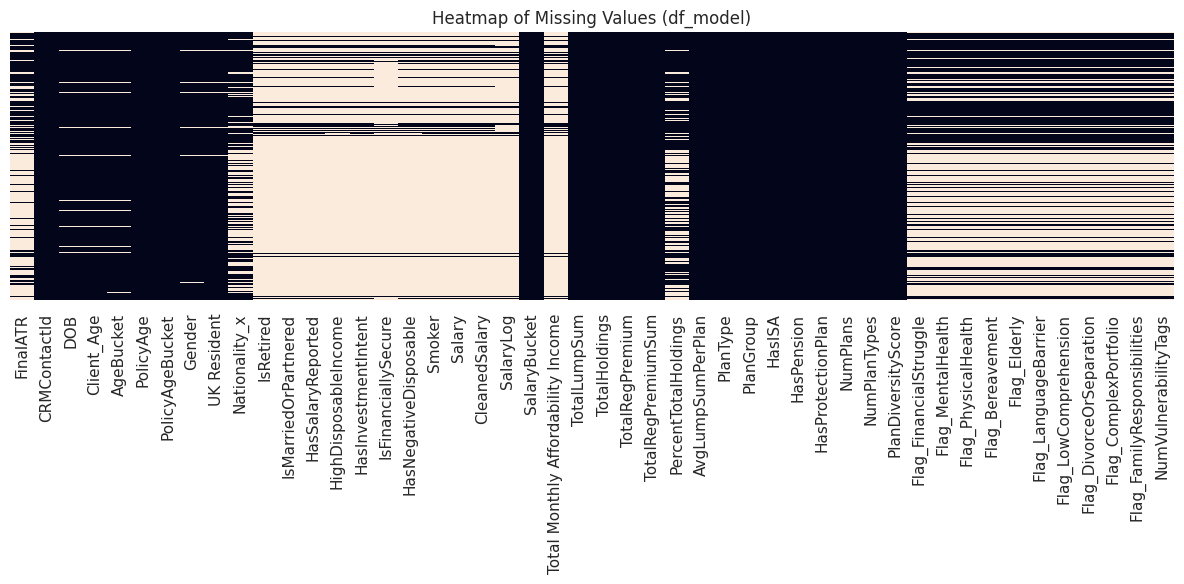

In [24]:
# === 📊 Dataset Diagnostics & Missingness Summary ===

# 📐 Basic shape and dtypes
print("🧩 Dataset shape:", df_model.shape)
print("\n📌 Data types:")
print(df_model.dtypes)

# 🔢 Summary for numeric features
numeric_summary = df_model.describe(include='number').transpose()
display(numeric_summary)

# 🔤 Summary for object/categorical features
categorical_summary = df_model.describe(include='object').transpose()
display(categorical_summary)

# 🚫 Missing data check
missing_summary = df_model.isnull().sum().to_frame(name='Missing Count')
missing_summary['% Missing'] = 100 * missing_summary['Missing Count'] / len(df_model)
missing_summary = missing_summary.sort_values(by='% Missing', ascending=False)

# Highlight critical missing columns
print("⚠️ Columns with >80% missing:")
display(missing_summary[missing_summary['% Missing'] > 80])

# 📉 Display top 10 missing
display(missing_summary.head(10))

# (Optional) 🔥 Heatmap of missing values — only for preview
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df_model.isnull(), cbar=False, yticklabels=False)
plt.title("Heatmap of Missing Values (df_model)")
plt.tight_layout()
plt.show()


🎯 PlanType Buckets:


,count
PlanType_Bucketed,
Other,11998
Group Personal Pension,9743
Personal Pension Plan,8060
ISA,5789
Term Protection,4913
Cash Account,4611
Group Death In Service,3837
Savings Account,1784
Mortgage,1735


🌍 Nationality Buckets:


,count
Nationality_Bucketed,
British,35626
Other,24792


🧑‍🏭 Occupation Group Buckets:


,count
OccupationGroup,
Unknown,4833
Executive,967
Technical,389
Managerial,355
Administrative,296
Retired,132
Healthcare,87
Education,70
Manual/Labour,57


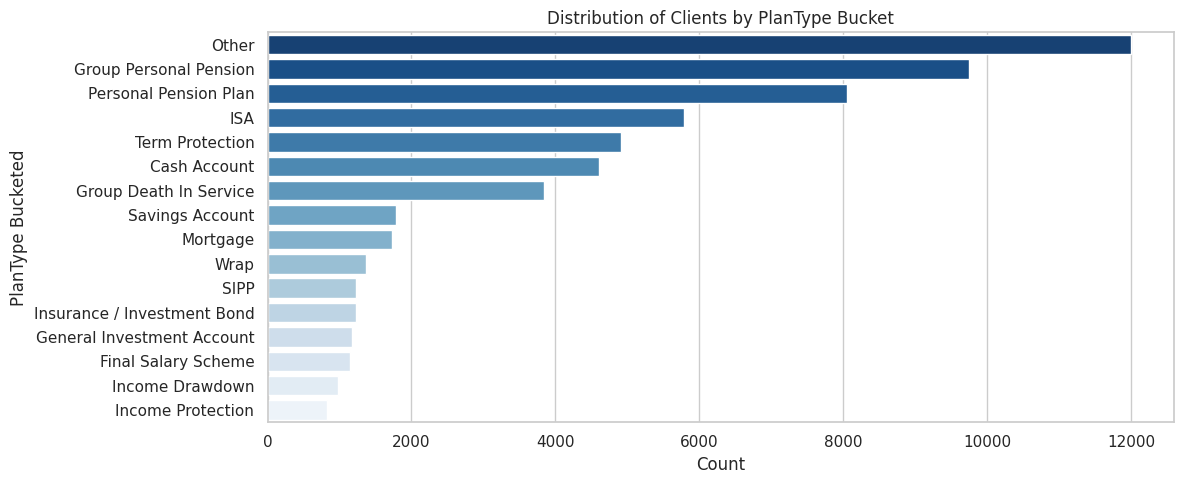

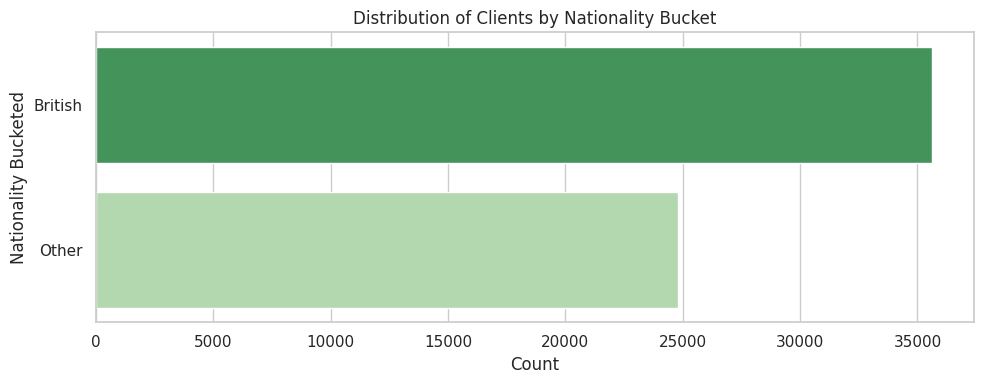

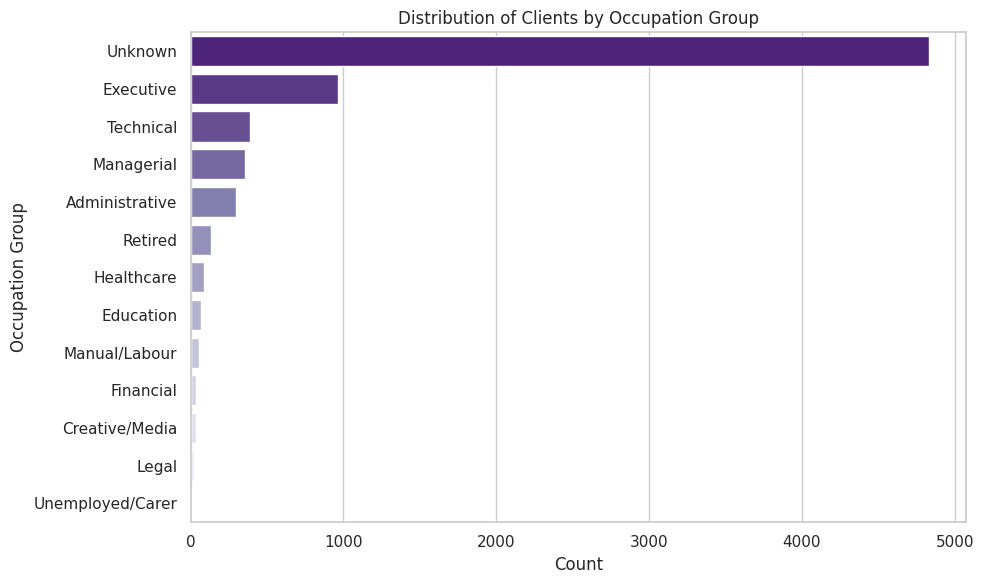

In [25]:
# === 2.12: High Cardinality Bucketing ===

def top_n_bucketer(df, colname, top_n=10, label="Other"):
    """
    Replace all but the top_n most common values in a column with 'Other'.
    """
    top_values = df[colname].value_counts().nlargest(top_n).index
    return df[colname].apply(lambda x: x if x in top_values else label)

# Simplify to British vs Other
df_model['Nationality_Bucketed'] = df_model['Nationality_x'].apply(
    lambda x: 'British' if x == 'British' else 'Other'
)

# 💼 PlanType: top 15 only
df_model['PlanType_Bucketed'] = top_n_bucketer(df_model, 'PlanType', top_n=15)

# 🧑‍🏭 Occupation: already has a grouped version, so let's drop original if present
if 'Occupation Group' in df_merged_cleaned.columns:
    df_model['OccupationGroup'] = df_merged_cleaned['Occupation Group']
elif 'Occupation' in df_model.columns:
    df_model['OccupationGroup'] = top_n_bucketer(df_model, 'Occupation', top_n=10)

# Merge 'Other/Unknown' into 'Unknown'
df_model['OccupationGroup'] = df_model['OccupationGroup'].replace('Other/Unknown', 'Unknown')

# ✅ Show value counts for review
print("🎯 PlanType Buckets:")
display(df_model['PlanType_Bucketed'].value_counts())

print("🌍 Nationality Buckets:")
display(df_model['Nationality_Bucketed'].value_counts())

print("🧑‍🏭 Occupation Group Buckets:")
display(df_model['OccupationGroup'].value_counts())

# 📊 Visualise Bucketed PlanType
plt.figure(figsize=(12, 5))
sns.countplot(data=df_model, y='PlanType_Bucketed', order=df_model['PlanType_Bucketed'].value_counts().index, palette='Blues_r')
plt.title("Distribution of Clients by PlanType Bucket")
plt.xlabel("Count")
plt.ylabel("PlanType Bucketed")
plt.tight_layout()
plt.show()

# 🌍 Visualise Bucketed Nationality
plt.figure(figsize=(10, 4))
sns.countplot(data=df_model, y='Nationality_Bucketed', order=df_model['Nationality_Bucketed'].value_counts().index, palette='Greens_r')
plt.title("Distribution of Clients by Nationality Bucket")
plt.xlabel("Count")
plt.ylabel("Nationality Bucketed")
plt.tight_layout()
plt.show()

# 🧑‍💼 Visualise OccupationGroup
plt.figure(figsize=(10, 6))
sns.countplot(data=df_model, y='OccupationGroup', order=df_model['OccupationGroup'].value_counts().index, palette='Purples_r')
plt.title("Distribution of Clients by Occupation Group")
plt.xlabel("Count")
plt.ylabel("Occupation Group")
plt.tight_layout()
plt.show()



In [26]:
binary_cols = ['IsRetired', 'IsMarriedOrPartnered', 'HasSalaryReported', 'HighDisposableIncome',
               'HasInvestmentIntent', 'IsFinanciallySecure', 'HasNegativeDisposable', 'Smoker',
               'Flag_FinancialStruggle', 'Flag_MentalHealth', 'Flag_PhysicalHealth',
               'Flag_Bereavement', 'Flag_Elderly', 'Flag_LanguageBarrier', 'Flag_LowComprehension',
               'Flag_DivorceOrSeparation', 'Flag_ComplexPortfolio', 'Flag_FamilyResponsibilities']

# Loop through and show value counts
for col in binary_cols:
    print(f"\n📊 Column: {col}")
    print(f"Data Type: {df_model[col].dtype}")
    print(df_model[col].value_counts(dropna=False).to_frame(name='Count'))



📊 Column: IsRetired
Data Type: object
           Count
IsRetired       
NaN        53136
False       4742
True        2540

📊 Column: IsMarriedOrPartnered
Data Type: object
                      Count
IsMarriedOrPartnered       
NaN                   53136
True                   5174
False                  2108

📊 Column: HasSalaryReported
Data Type: object
                   Count
HasSalaryReported       
NaN                53136
True                5779
False               1503

📊 Column: HighDisposableIncome
Data Type: float64
                      Count
HighDisposableIncome       
NaN                   53773
0.0                    5275
1.0                    1370

📊 Column: HasInvestmentIntent
Data Type: object
                     Count
HasInvestmentIntent       
NaN                  53136
True                  5059
False                 2223

📊 Column: IsFinanciallySecure
Data Type: float64
                     Count
IsFinanciallySecure       
NaN                  55359
0.0     

,% True
HasSalaryReported,79.360066
HasPension,72.005032
IsMarriedOrPartnered,71.051909
HasInvestmentIntent,69.472672
HasISA,38.308120
IsRetired,34.880527
HasNegativeDisposable,28.788563
HighDisposableIncome,20.617005
Flag_FinancialStruggle,16.693526
Flag_LowComprehension,14.493414


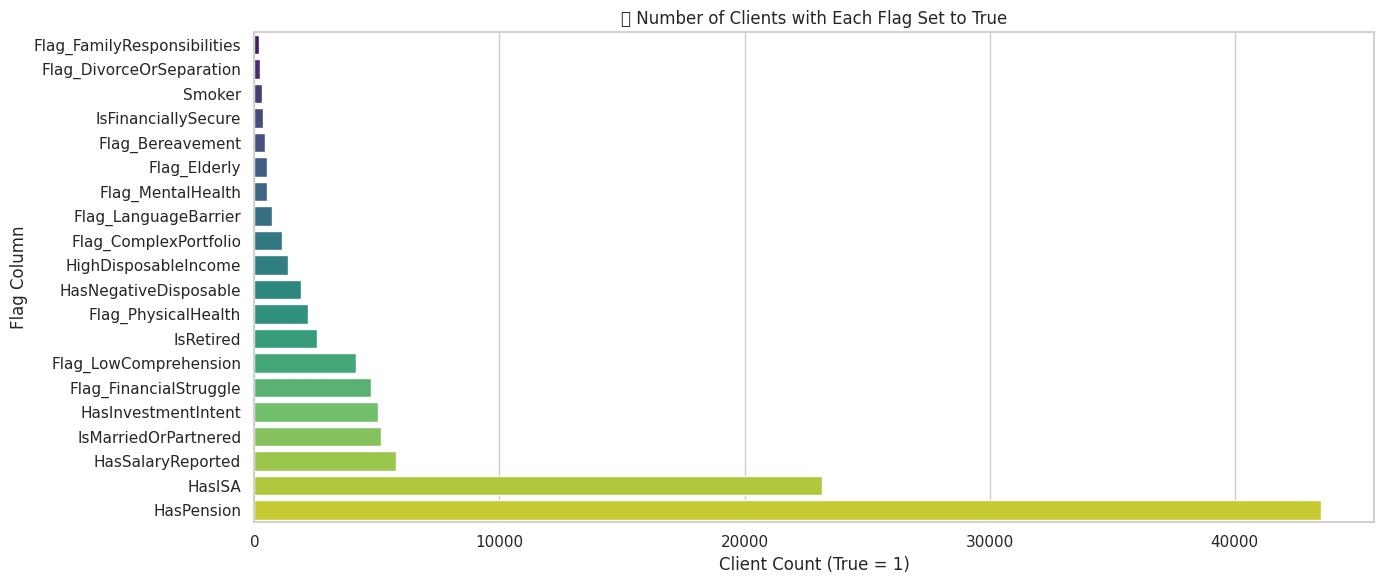

In [27]:
# 📌 Step 2.13 – Binary Indicator Column Cleanup and Summary

# Define binary-like columns to normalize
binary_cols = [
    'IsRetired', 'IsMarriedOrPartnered', 'HasSalaryReported', 'HighDisposableIncome',
    'HasInvestmentIntent', 'IsFinanciallySecure', 'HasNegativeDisposable', 'Smoker',
    'Flag_FinancialStruggle', 'Flag_MentalHealth', 'Flag_PhysicalHealth', 'Flag_Bereavement',
    'Flag_Elderly', 'Flag_LanguageBarrier', 'Flag_LowComprehension',
    'Flag_DivorceOrSeparation', 'Flag_ComplexPortfolio', 'Flag_FamilyResponsibilities',
    'HasISA', 'HasPension'  # Included as consistent binary flags
]

# Step 1: Normalize binary columns (True/False to 1/0)
for col in binary_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].replace({'True': 1, 'False': 0, True: 1, False: 0})
        if col == 'Smoker':
            df_model[col] = df_model[col].replace({'unanswered': np.nan})
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Step 2: Summary table showing % of True values
binary_summary = pd.DataFrame(index=binary_cols)
binary_summary['% True'] = df_model[binary_cols].apply(
    lambda x: 100 * x.sum(skipna=True) / x.notna().sum()
)
binary_summary = binary_summary.sort_values(by='% True', ascending=False)
display(binary_summary)

# Step 3: Bar plot showing count of True values
true_counts = df_model[binary_cols].sum().sort_values(ascending=True)

plt.figure(figsize=(14, 6))
sns.barplot(x=true_counts.values, y=true_counts.index, palette='viridis')
plt.title("📊 Number of Clients with Each Flag Set to True")
plt.xlabel("Client Count (True = 1)")
plt.ylabel("Flag Column")
plt.tight_layout()
plt.show()


In [28]:
# Reuse binary_cols to exclude already handled ones
binary_cols_handled = set([
    'IsRetired', 'IsMarriedOrPartnered', 'HasSalaryReported', 'HighDisposableIncome',
    'HasInvestmentIntent', 'IsFinanciallySecure', 'HasNegativeDisposable', 'Smoker',
    'Flag_FinancialStruggle', 'Flag_MentalHealth', 'Flag_PhysicalHealth',
    'Flag_Bereavement', 'Flag_Elderly', 'Flag_LanguageBarrier', 'Flag_LowComprehension',
    'Flag_DivorceOrSeparation', 'Flag_ComplexPortfolio', 'Flag_FamilyResponsibilities'
])

# Find candidates
potential_binaries = []
for col in df_model.columns:
    if col in binary_cols_handled:
        continue
    if df_model[col].dtype in ['object', 'float64']:
        unique_vals = df_model[col].dropna().unique()
        if set(unique_vals).issubset({0, 1, 'True', 'False', True, False}):
            potential_binaries.append(col)

print("🕵️‍♂️ Additional potential binary columns not yet cleaned:")
print(potential_binaries)


🕵️‍♂️ Additional potential binary columns not yet cleaned:
['HasISA', 'HasPension']


🧮 Summary of Row-Level Missing Fields:


,NumMissingFields
count,60418.000000
mean,18.873763
std,8.764583
min,0.000000
25%,13.000000
50%,24.000000
75%,27.000000
max,32.000000


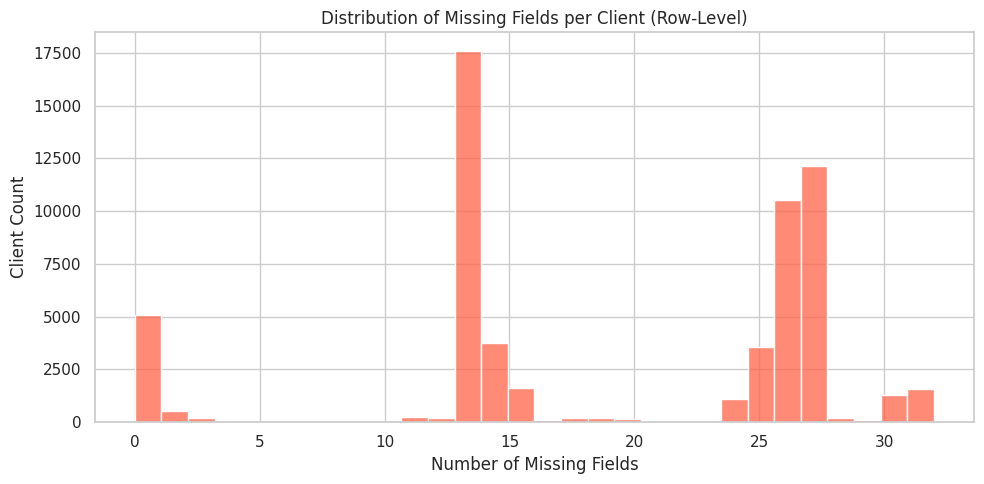

In [31]:
# ✅ Add row-level missingness helper column
df_model['NumMissingFields'] = df_model.isnull().sum(axis=1)

# 🔍 Summary statistics
print("🧮 Summary of Row-Level Missing Fields:")
display(df_model['NumMissingFields'].describe())

# 📊 Visualise
plt.figure(figsize=(10, 5))
sns.histplot(df_model['NumMissingFields'], bins=30, kde=False, color='tomato')
plt.title("Distribution of Missing Fields per Client (Row-Level)")
plt.xlabel("Number of Missing Fields")
plt.ylabel("Client Count")
plt.tight_layout()
plt.show()

# 💡 Note:
# `NumMissingFields` could be used as:
# - A filtering criterion (e.g. drop rows with > 30 missing fields before modelling)
# - A proxy for client data quality or segmentation later

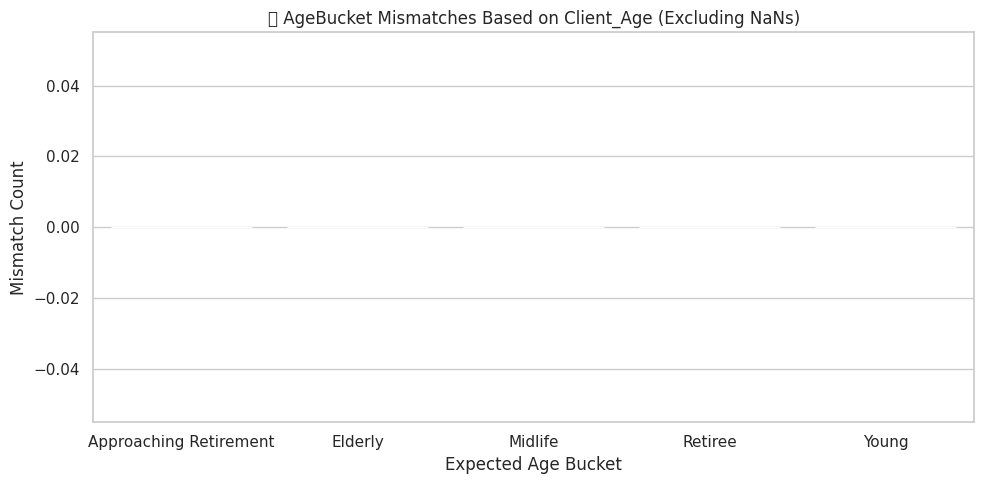

✅ Revised mismatch breakdown (excluding NaNs):


,count
AgeBucket_Mismatch,
False,57307


In [35]:
# 🧪 Define expected mapping from Client_Age to AgeBucket label
def expected_age_bucket(age):
    if pd.isna(age):
        return np.nan
    elif age < 40:
        return 'Young'
    elif age < 50:
        return 'Midlife'
    elif age < 60:
        return 'Approaching Retirement'
    elif age < 75:
        return 'Retiree'
    else:
        return 'Elderly'

# 🔍 Calculate expected bucket and compare to actual
df_merged['Expected_AgeBucket'] = df_merged['Client_Age'].apply(expected_age_bucket)
df_merged['AgeBucket_Mismatch'] = df_merged['AgeBucket'] != df_merged['Expected_AgeBucket']

# 🧼 Exclude rows where either value is NaN (uncomparable)
valid_mask = df_merged[['AgeBucket', 'Expected_AgeBucket']].notna().all(axis=1)
df_agecheck = df_merged[valid_mask]

# ✅ Mismatch summary
mismatch_summary = df_agecheck.groupby('Expected_AgeBucket')['AgeBucket_Mismatch'].sum().reset_index()
mismatch_summary = mismatch_summary.sort_values(by='AgeBucket_Mismatch', ascending=False)

# 📊 Visualise mismatches
plt.figure(figsize=(10, 5))
sns.barplot(data=mismatch_summary, x='Expected_AgeBucket', y='AgeBucket_Mismatch')
plt.title("🔎 AgeBucket Mismatches Based on Client_Age (Excluding NaNs)")
plt.xlabel("Expected Age Bucket")
plt.ylabel("Mismatch Count")
plt.tight_layout()
plt.show()

# 🧾 Show updated totals
print("✅ Revised mismatch breakdown (excluding NaNs):")
display(df_agecheck['AgeBucket_Mismatch'].value_counts())


#can probably delete this. used to confirm the bucket matching worked


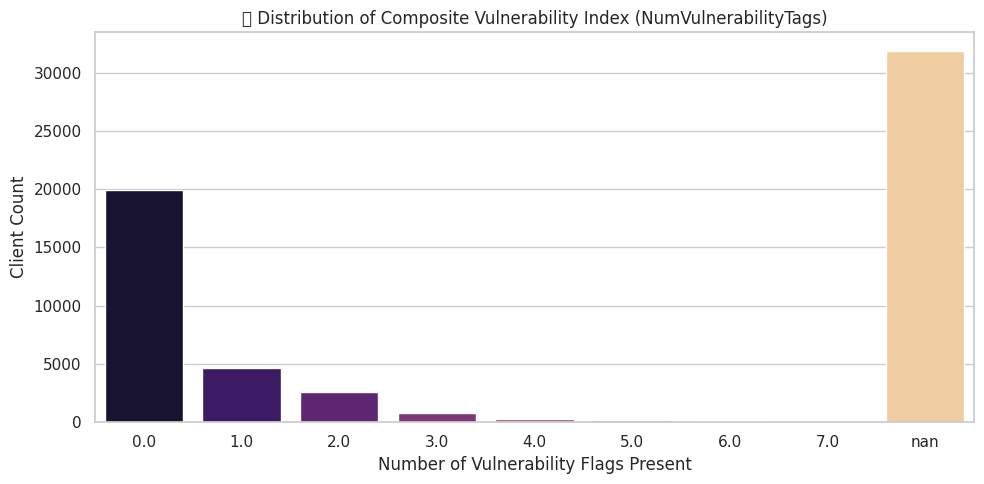

📊 Summary of Non-Null NumVulnerabilityTags:


,NumVulnerabilityTags
count,28544.000000
mean,0.519829
std,0.965704
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,7.000000


In [37]:
# 📌 2.17: Composite Vulnerability Index — Distribution and Summary

# Step 1: Frequency of vulnerability tag counts (including NaNs for context)
vuln_counts = df_model['NumVulnerabilityTags'].value_counts(dropna=False).sort_index()

# Step 2: Bar chart of number of vulnerability flags per client
plt.figure(figsize=(10, 5))
sns.barplot(x=vuln_counts.index.astype(str), y=vuln_counts.values, palette='magma')
plt.title("🧱 Distribution of Composite Vulnerability Index (NumVulnerabilityTags)")
plt.xlabel("Number of Vulnerability Flags Present")
plt.ylabel("Client Count")
plt.tight_layout()
plt.show()

# Step 3: Summary statistics (excluding NaNs)
vuln_summary = df_model['NumVulnerabilityTags'].describe()
print("📊 Summary of Non-Null NumVulnerabilityTags:")
display(vuln_summary)


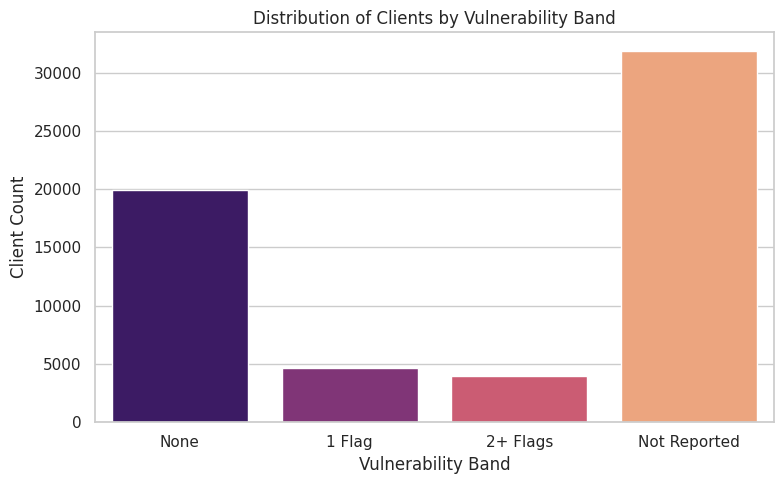

📦 Vulnerability Band Counts:


,count
VulnerabilityBand,
Not Reported,31874
None,19932
1 Flag,4632
2+ Flags,3980


In [38]:
# 🔁 Band and fill missing with 'Not Reported'
def band_vulnerability_count(x):
    if pd.isnull(x):
        return 'Not Reported'
    elif x == 0:
        return 'None'
    elif x == 1:
        return '1 Flag'
    else:
        return '2+ Flags'

df_model['VulnerabilityBand'] = df_model['NumVulnerabilityTags'].apply(band_vulnerability_count)

# 📊 Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_model, x='VulnerabilityBand',
              order=['None', '1 Flag', '2+ Flags', 'Not Reported'],
              palette='magma')
plt.title("Distribution of Clients by Vulnerability Band")
plt.xlabel("Vulnerability Band")
plt.ylabel("Client Count")
plt.tight_layout()
plt.show()

# 🧮 Count values
print("📦 Vulnerability Band Counts:")
display(df_model['VulnerabilityBand'].value_counts(dropna=False))


In [39]:
df_model.head()

,FinalATR,CRMContactId,DOB,Client_Age,AgeBucket,PolicyAge,PolicyAgeBucket,Gender,UK Resident,Nationality_x,IsRetired,IsMarriedOrPartnered,HasSalaryReported,HighDisposableIncome,HasInvestmentIntent,IsFinanciallySecure,HasNegativeDisposable,Smoker,Salary,CleanedSalary,SalaryLog,SalaryBucket,Total Monthly Affordability Income,TotalLumpSum,TotalHoldings,TotalRegPremium,TotalRegPremiumSum,PercentTotalHoldings,AvgLumpSumPerPlan,PlanType,PlanGroup,HasISA,HasPension,HasProtectionPlan,NumPlans,NumPlanTypes,PlanDiversityScore,Flag_FinancialStruggle,Flag_MentalHealth,Flag_PhysicalHealth,Flag_Bereavement,Flag_Elderly,Flag_LanguageBarrier,Flag_LowComprehension,Flag_DivorceOrSeparation,Flag_ComplexPortfolio,Flag_FamilyResponsibilities,NumVulnerabilityTags,Nationality_Bucketed,PlanType_Bucketed,OccupationGroup,NumMissingFields,DerivedAgeBucket,AgeBucket_Mismatch,VulnerabilityBand
0,NaN,12444405,1972-10-25,52.0,Approaching Retirement,16.2,10y+,Male,True,British,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoSalary,NaN,10092.27,30013.27,0.0,0.0,0.336260,15006.635000,Personal Pension Plan,Pension,0.0,1.0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,British,Personal Pension Plan,NaN,25,Approaching Retirement,False,Not Reported
1,NaN,12444405,1972-10-25,52.0,Approaching Retirement,8.6,5-10y,Male,True,British,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoSalary,NaN,19921.00,30013.27,0.0,0.0,0.663740,15006.635000,Group Personal Pension,Pension,0.0,1.0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,British,Group Personal Pension,NaN,25,Approaching Retirement,False,Not Reported
2,5.0,12444408,1943-02-11,82.0,Elderly,0.2,<1y,Male,True,British,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,102739.0,102739.0,11.539957,Top,9253.97,0.00,7884284.45,0.0,297.1,0.000000,414962.339474,Cash Account,Savings/Deposit,1.0,1.0,0,19,11,6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,British,Cash Account,Unknown,0,Elderly,False,2+ Flags
3,5.0,12444408,1943-02-11,82.0,Elderly,12.2,10y+,Male,True,British,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,102739.0,102739.0,11.539957,Top,9253.97,207706.40,7884284.45,0.0,297.1,0.026344,414962.339474,Pension Annuity,Pension,1.0,1.0,0,19,11,6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,British,Other,Unknown,0,Elderly,False,2+ Flags
4,5.0,12444408,1943-02-11,82.0,Elderly,19.9,10y+,Male,True,British,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,102739.0,102739.0,11.539957,Top,9253.97,306549.68,7884284.45,0.0,297.1,0.038881,414962.339474,ISA,ISA,1.0,1.0,0,19,11,6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,British,ISA,Unknown,0,Elderly,False,2+ Flags


📊 FinalATR value counts (including NaN):


,Count
FinalATR,
NaN,35399
5.0,7871
6.0,7409
7.0,3747
4.0,3363
8.0,1597
3.0,505
9.0,199
1.0,198


📈 FinalATR percentage breakdown (non-null only):


,% of Total
FinalATR,
1.0,0.791399
2.0,0.479635
3.0,2.018466
4.0,13.441784
5.0,31.460090
6.0,29.613494
7.0,14.976618
8.0,6.383149
9.0,0.795395


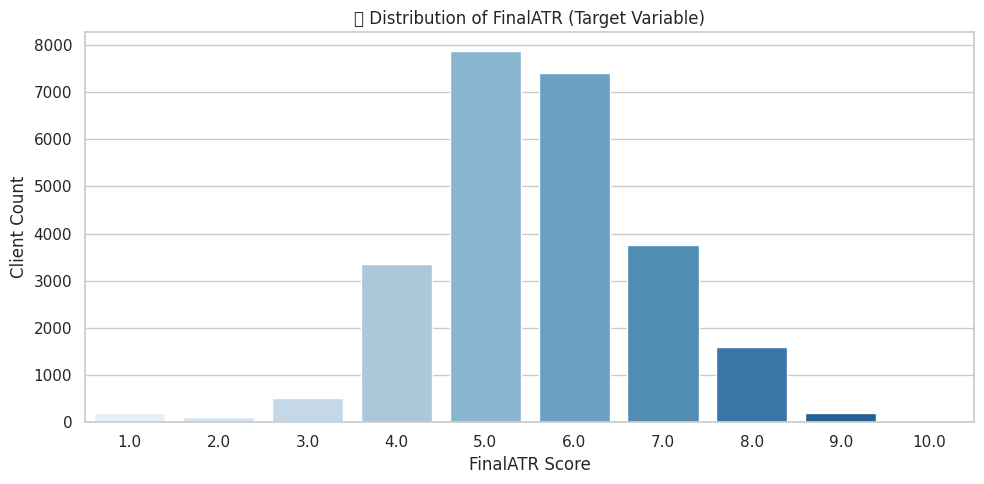

❌ Missing FinalATR values: 35,399 (58.59%)
Skewness: -0.15
Mean: 5.60
Median: 6.00
Mode: [5.]


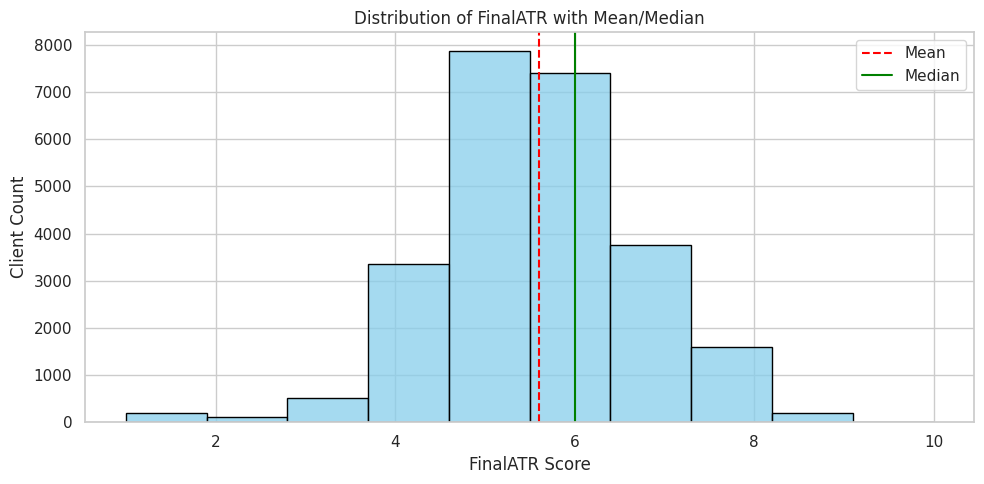

In [30]:
# 🎯 Inspect FinalATR target variable

# Step 1 – Summary stats
print("📊 FinalATR value counts (including NaN):")
display(df_model['FinalATR'].value_counts(dropna=False).to_frame(name='Count'))

# Step 2 – Percentage breakdown (excluding NaNs)
finalatr_percentages = df_model['FinalATR'].value_counts(normalize=True, dropna=True) * 100
print("📈 FinalATR percentage breakdown (non-null only):")
display(finalatr_percentages.to_frame(name='% of Total').sort_index())

# Step 3 – Plot distribution (excluding missing values)
plt.figure(figsize=(10, 5))
sns.countplot(data=df_model, x='FinalATR', palette='Blues', order=sorted(df_model['FinalATR'].dropna().unique()))
plt.title("🎯 Distribution of FinalATR (Target Variable)")
plt.xlabel("FinalATR Score")
plt.ylabel("Client Count")
plt.tight_layout()
plt.show()

# Step 4 – Report missing
num_missing_target = df_model['FinalATR'].isnull().sum()
print(f"❌ Missing FinalATR values: {num_missing_target:,} ({num_missing_target / len(df_model):.2%})")

# 📐 Summary statistics for FinalATR
finalatr_series = df_model['FinalATR'].dropna()

print(f"Skewness: {finalatr_series.skew():.2f}")
print(f"Mean: {finalatr_series.mean():.2f}")
print(f"Median: {finalatr_series.median():.2f}")
print(f"Mode: {finalatr_series.mode().values}")

# 📊 Histogram with mean and median
plt.figure(figsize=(10, 5))
sns.histplot(finalatr_series, bins=10, kde=False, color='skyblue', edgecolor='black')
plt.axvline(finalatr_series.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(finalatr_series.median(), color='green', linestyle='-', label='Median')
plt.title("Distribution of FinalATR with Mean/Median")
plt.xlabel("FinalATR Score")
plt.ylabel("Client Count")
plt.legend()
plt.tight_layout()
plt.show()

### Conclusion: The FinalATR variable is well suited to:

###Regression, or

###Ordinal classification, or

###A banded categorical score (to simplify tail class imbalance — we’ll do that later in 2.20).


### 📌 Outstanding or Optional Enhancements (Phase 2 Tracker)

- [ ] Investigate feature importance of `SalaryBucket` post-model: drop or re-bucket if weak.
- [ ] Validate if `Client_Age` or `PolicyAge` ever conflict with their buckets.
- [ ] Check for extreme outliers in `CleanedSalary`: Top 10 by value.
- [ ] Confirm if `PlanDiversityScore` has strong variation or needs normalisation.
- [ ] Create missingness summary (row-level) and investigate clustered gaps.
- [ ] Impute or re-encode high-missing features (if used in modelling).
- [ ] Evaluate composite vulnerability score vs. `NumVulnerabilityTags`.
- [ ] Nationality collapsed to "British" vs "Other" due to extreme skew (95%+ British).
- [ ] Occupation "Other/Unknown" merged into "Unknown" to eliminate redundancy.
- [ ] Potentially collapse rare OccupationGroup values if they contribute little signal or model instability.